In [2]:
from datetime import date, datetime, timedelta
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVR, LinearSVR
import seaborn as sns
import xgboost as xgb

In [22]:
#import data
data = pd.read_csv('~/python_files/sp_high_speed_rail.csv')

In [23]:
# explore data
print(data.dtypes)
data.head()

Unnamed: 0       int64
insert_date     object
origin          object
destination     object
start_date      object
end_date        object
train_type      object
price          float64
train_class     object
fare            object
dtype: object


,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
1,1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo
2,2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo
3,3,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.40,Preferente,Promo
4,4,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:30:00,2019-05-29 11:14:00,ALVIA,NaN,Turista,Promo


In [24]:
# Drop unneeded trip ID column
data.drop(['Unnamed: 0', 'insert_date'], axis='columns', inplace=True)

In [25]:
data.tail()

,origin,destination,start_date,end_date,train_type,price,train_class,fare
2579766,MADRID,SEVILLA,2019-05-30 19:00:00,2019-05-30 21:38:00,AVE,76.30,Turista,Flexible
2579767,MADRID,SEVILLA,2019-05-30 19:30:00,2019-05-30 22:05:00,AVE,76.30,Turista,Flexible
2579768,MADRID,SEVILLA,2019-05-30 20:00:00,2019-05-30 22:21:00,AVE,72.30,Turista Plus,Promo
2579769,MADRID,SEVILLA,2019-05-30 20:35:00,2019-05-30 23:15:00,AVE,76.30,Turista,Flexible
2579770,MADRID,SEVILLA,2019-05-30 21:25:00,2019-05-31 00:10:00,AV City,49.15,Turista,Promo


In [26]:
#all other columns are object data, so let's describe the price column.
data.price.describe()

count    2.269090e+06
mean     6.338550e+01
std      2.578319e+01
min      1.545000e+01
25%      4.375000e+01
50%      6.030000e+01
75%      7.880000e+01
max      2.142000e+02
Name: price, dtype: float64

Looks like we are missing some rows, so we'll have to address that.

In [27]:
#perform any manipulations to fix the data for modeling
#Check unique values and NaNs for each column, excluding the trip ID column
for col in data.columns:
    column = data[col]
    print('column:', col)
    print('unique vals:', column.nunique())
    print('nan vals:', column.isnull().sum())
    print()

column: origin
unique vals: 5
nan vals: 0

column: destination
unique vals: 5
nan vals: 0

column: start_date
unique vals: 8090
nan vals: 0

column: end_date
unique vals: 10736
nan vals: 0

column: train_type
unique vals: 16
nan vals: 0

column: price
unique vals: 225
nan vals: 310681

column: train_class
unique vals: 6
nan vals: 9664

column: fare
unique vals: 7
nan vals: 9664



It's looking like we have some clear candidates for creating dummy variables (origin, destination, train_type, train_class, and fare). We can also turn the start_date and end_date into useful variables by subtracting to get a trip duration, and possibly making dummy columns for day of week or time of day (morning, midday, night). But first, let's look into the null values.

### Addressing Nan values

Our train_class and fare columns have the same number of Nan values. Do they occur in the same rows?

In [28]:
nas = data[data['fare'].isna()]
nas[~nas['train_class'].isna()]

,origin,destination,start_date,end_date,train_type,price,train_class,fare


They completely overlap. And is there any overlap with the price column Nan values?

In [29]:
nas[~nas['price'].isna()]

,origin,destination,start_date,end_date,train_type,price,train_class,fare


There is! Because all three rows share their Nans, and price is our target, removing all rows with Nan prices will take care of our problem.

In [30]:
data = data[data['price'].notnull()]
data.shape[0]

2269090

In [31]:
#A column with trip durations would perhaps be helpful. Probably best formatted in seconds.
data['start_date'] = pd.to_datetime(data['start_date'])
data['end_date'] = pd.to_datetime(data['end_date'])
data['trip_duration'] = (data['end_date'] - data['start_date'])/np.timedelta64(1, 's')
data.head()

,origin,destination,start_date,end_date,train_type,price,train_class,fare,trip_duration
0,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo,10560.0
1,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo,9120.0
2,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo,8460.0
3,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.40,Preferente,Promo,9120.0
5,MADRID,SEVILLA,2019-05-29 09:00:00,2019-05-29 11:38:00,AVE,60.30,Turista,Promo,9480.0


In [32]:
print(data.trip_duration.dtype)

float64


# Visualizations

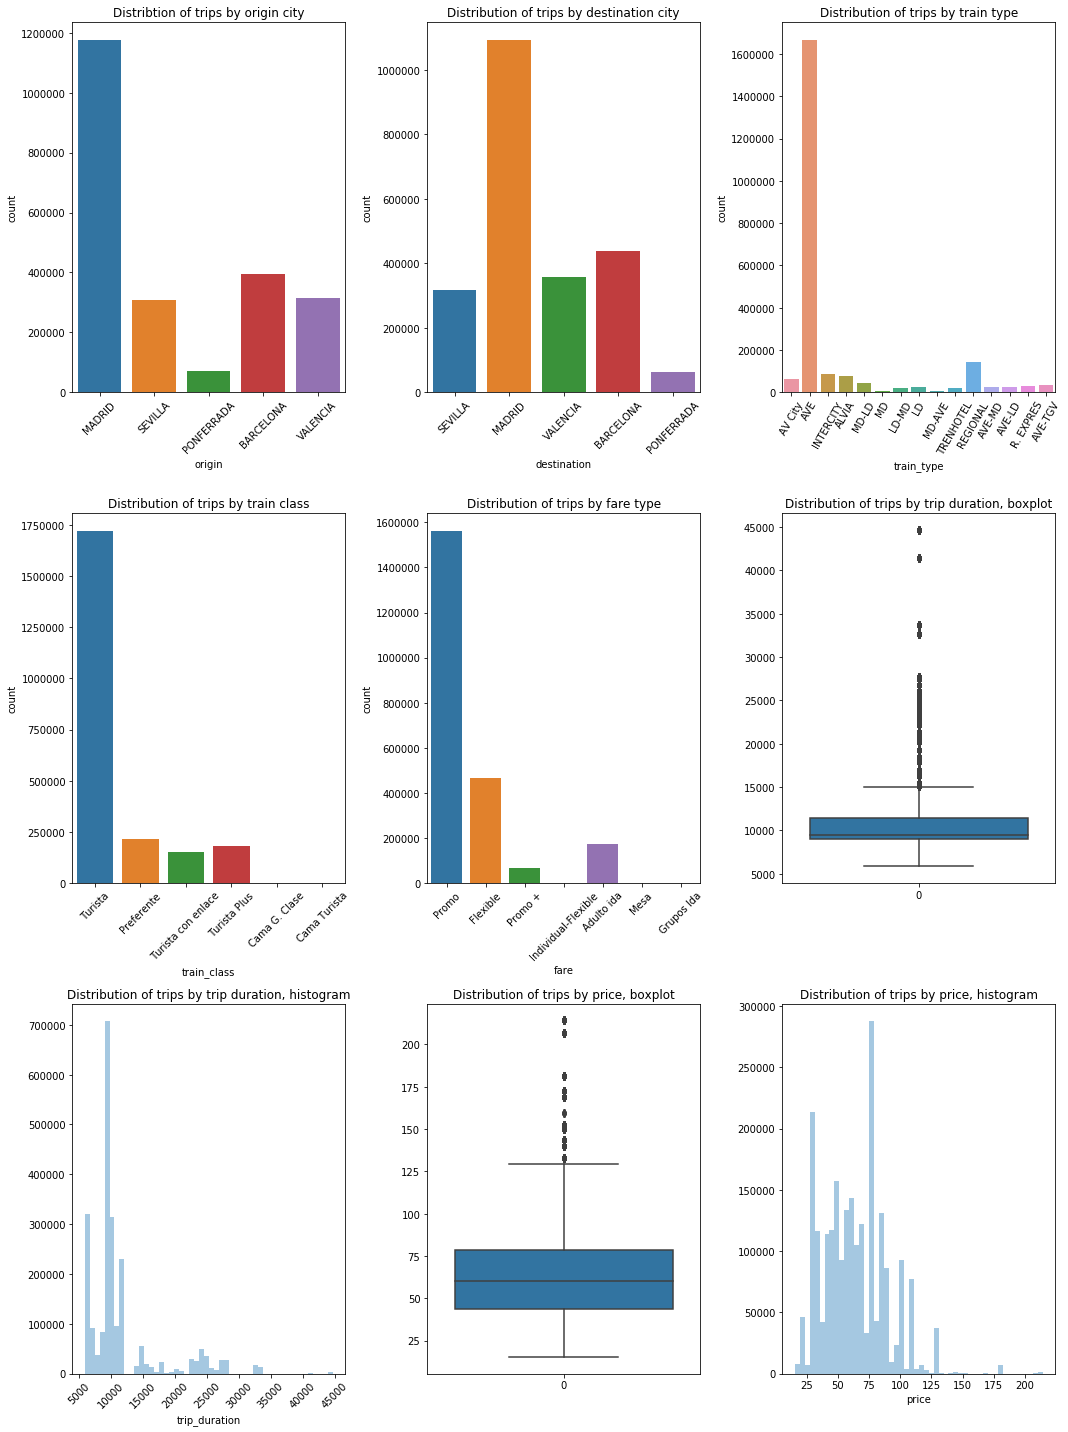

In [33]:
#Visually explore the data...beginning here before we create the dummy columns.
plt.figure(figsize=(15, 20))

plt.subplot(3, 3, 1)
sns.countplot(x='origin', data=data)
plt.title('Distribtion of trips by origin city')
plt.xticks(rotation=45)

plt.subplot(3, 3, 2)
sns.countplot(x='destination', data=data)
plt.title('Distribution of trips by destination city')
plt.xticks(rotation=45)

plt.subplot(3, 3, 3)
sns.countplot(x='train_type', data=data)
plt.title('Distribution of trips by train type')
plt.xticks(rotation=60)

plt.subplot(3, 3, 4)
sns.countplot(x='train_class', data=data)
plt.title('Distribution of trips by train class')
plt.xticks(rotation=45)

plt.subplot(3, 3, 5)
sns.countplot(x='fare', data=data)
plt.title('Distribution of trips by fare type')
plt.xticks(rotation=45)

plt.subplot(3, 3, 6)
sns.boxplot(data=data.trip_duration)
plt.title('Distribution of trips by trip duration, boxplot')

plt.subplot(3, 3, 7)
sns.distplot(data.trip_duration, kde=False)
plt.title('Distribution of trips by trip duration, histogram')
plt.xticks(rotation=45)

plt.subplot(3, 3, 8)
sns.boxplot(data=data.price)
plt.title('Distribution of trips by price, boxplot')

plt.subplot(3, 3, 9)
sns.distplot(data.price, kde=False)
plt.title('Distribution of trips by price, histogram')

plt.tight_layout()
plt.show()

## Bivariate visualization

## Feature Engineering

Now that we have our baseline accuracy, we'll get into engineering a few date-time related features to see if we can improve our model accuracy.

In [34]:
# origin, destination, train_type, train_class, and fare all need to be dummied
data = pd.get_dummies(data, columns=['origin', 'destination', 'train_type', 'train_class', 'fare'])

In [35]:
# For now, get rid of start_date and end_date in features until I decide if I should create more features from them
features = data.drop(['start_date', 'end_date'], axis=1)
features.head()

,price,trip_duration,origin_BARCELONA,origin_MADRID,origin_PONFERRADA,origin_SEVILLA,origin_VALENCIA,destination_BARCELONA,destination_MADRID,destination_PONFERRADA,...,train_class_Turista,train_class_Turista Plus,train_class_Turista con enlace,fare_Adulto ida,fare_Flexible,fare_Grupos Ida,fare_Individual-Flexible,fare_Mesa,fare_Promo,fare_Promo +
0,38.55,10560.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,53.40,9120.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,47.30,8460.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,69.40,9120.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,60.30,9480.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [36]:
print(data.start_date.dtype)

datetime64[ns]


In [37]:
data.start_date.head(5)

0   2019-05-29 06:20:00
1   2019-05-29 07:00:00
2   2019-05-29 07:30:00
3   2019-05-29 08:00:00
5   2019-05-29 09:00:00
Name: start_date, dtype: datetime64[ns]

In [38]:
data['weekday'] = data['start_date'].dt.weekday

In [39]:
data.weekday.head(5)

0    2
1    2
2    2
3    2
5    2
Name: weekday, dtype: int64

In [40]:
#Need to check on which value the week starts
data.weekday.unique()

array([2, 1, 6, 5, 4, 3, 0])

In [41]:
#Create features of weekend days, weekend adjacent days, and the rest (middle of week)
features['sat_sun'] = np.where((data['weekday'] == 5) | (data['weekday'] == 6), 1, 0)
features['fri_mon'] = np.where((data['weekday'] == 0) | (data['weekday'] == 4), 1, 0)
features['midweek'] = np.where((data['weekday'] == 1) | (data['weekday'] == 2) | (data['weekday'] == 3), 1, 0)

In [42]:
features.head()

,price,trip_duration,origin_BARCELONA,origin_MADRID,origin_PONFERRADA,origin_SEVILLA,origin_VALENCIA,destination_BARCELONA,destination_MADRID,destination_PONFERRADA,...,fare_Adulto ida,fare_Flexible,fare_Grupos Ida,fare_Individual-Flexible,fare_Mesa,fare_Promo,fare_Promo +,sat_sun,fri_mon,midweek
0,38.55,10560.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,53.40,9120.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,47.30,8460.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,69.40,9120.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
5,60.30,9480.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


#### Creating an hour column based on start_date so I can create features of departure windows.

In [43]:
#Create Hour column
data['hour'] = data['start_date'].dt.hour

#Create columns for different depart windows
features['dep_8-12'] = np.where((data['hour'] >= 8) & (data['hour'] < 12), 1, 0)
features['dep_12-16'] = np.where((data['hour'] >= 12) & (data['hour'] < 16), 1, 0)
features['dep_16-20'] = np.where((data['hour'] >= 16) & (data['hour'] < 20), 1, 0)
features['dep_20-8'] = np.where((data['hour'] >= 20) | (data['hour'] < 8), 1, 0)

#check it worked
features.iloc[:9, 43:]

,dep_8-12,dep_12-16,dep_16-20,dep_20-8
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,1,0,0,0
5,1,0,0,0
6,1,0,0,0
7,1,0,0,0
8,1,0,0,0
10,0,1,0,0


# Create a custom scorer for evaluation

In [44]:
# Define Root Mean Squared Logarithmic Error function for use in project
def rmsle (actual, predicted):
    #conver to np.array, just to be safe.
    actual = np.array(actual)
    predicted = np.array(predicted)
    total_loss = 0.0
    for row in range(len(actual)):
        total_loss += (np.log(actual[row] + 1) - np.log(predicted[row] + 1)) ** 2
    return (total_loss / len(actual)) ** 0.5

# Create custom scorer to use this metric in cross validation
custom_scorer = make_scorer(rmsle, greater_is_better=False)

In [45]:
#Create training shuffle split
X = features.drop('price', axis=1)
Y = features['price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=87)

In [19]:
#Create Random Forest Regressor
rfr = ensemble.RandomForestRegressor(n_estimators=10, n_jobs=-1)

#Apply cross validation
#training_error = cross_val_score(rfr, X_train, Y_train, cv=5, scoring=custom_scorer)
#test_error = cross_val_score(rfr, X_test, Y_test, cv=5, scoring=custom_scorer)
#print('training error:', -1 * np.mean(training_error))
#print('test error:', -1 * np.mean(test_error))
rfr.fit(X_train, Y_train)
Y_pred = rfr.predict(X_test)
base_accuracy = rmsle(Y_test, Y_pred)
print(base_accuracy)

0.1570972632288453


# LinearSVR model

In [46]:
# Create X and Y train/test sets with 80-20 split
X = features.drop('price', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=87)

# For SVM scale X and Y, then create train/test sets with 50-50 split
X_train_50, X_test_50, Y_train_50, Y_test_50 = train_test_split(X, Y, test_size=0.5, random_state=87)

In [50]:
svr_model = LinearSVR(C=1, loss='squared_epsilon_insensitive', dual=False, verbose=1, random_state=87)
svr_model.fit(X_train, Y_train)

[LibLinear]

LinearSVR(C=1, dual=False, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='squared_epsilon_insensitive',
          max_iter=1000, random_state=87, tol=0.0001, verbose=1)

In [51]:
svm_y_pred = svr_model.predict(X_test)

In [52]:
rmsle(Y_test, svm_y_pred)

0.714153575048095

# Support Vector Regressor:

In [53]:
scaler = preprocessing.MinMaxScaler()
#Y_scaled = scaler.fit_transform(Y.to_frame())
X_scaled = scaler.fit_transform(X)

#### Create new train_test_split with scaled X and 80-20 split

In [54]:
# Create train_test_split with 
X_train_scaled, X_test_scaled, Y_train_s, Y_test_s = train_test_split(X_scaled, Y, test_size=0.2, random_state=87)

In [ ]:
svr_model2 = SVR(C=1, kernel='rbf', gamma='auto', verbose=2)
svr_model2.fit(X_train_scaled, Y_train_s)

[LibSVM]

In [35]:
Y_pred_2 = svr_model2.predict(X_test_50s)
rmsle(Y_test_50s, Y_pred_2)

array([0.04896521])

Now that we've created some new features, let's try our model again and see what the accuracy looks like.

## Modeling, round 2

In [55]:


rfr1 = ensemble.RandomForestRegressor(n_estimators=10, n_jobs=-1)
#cross validation
#train_error1 = cross_val_score(rfr1, X_train, Y_train, cv=5, scoring=custom_scorer)
#test_error1 = cross_val_score(rfr1, X_test, Y_test, cv=5, scoring=custom_scorer)

#print('training error of new model:', -1 * np.mean(train_error1))
rfr1.fit(X_train, Y_train)
Y_pred = rfr1.predict(X_test)

first_pass_accuracy = rmsle(Y_test, Y_pred)
print('model error after first feature engineering:', first_pass_accuracy)

model error after first feature engineering: 0.14127790623645675


### Our accuracy improved slightly, so let's move on to hyperparameter tuning to see if we can squeeze any more accuracy out of this model.

We'll start with a RandomizedSearchCV and a wide range grid values. This will help us narrow things down, from which point we can perform a GridSearchCV to find our ideal hyperparameters.

Let's start with making our test hyperparameters

In [92]:
#number of trees
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
#Max node depth
max_depth = [int(x) for x in np.linspace(start=4, stop=10, num=4)]
max_depth.append(None)
#Minimum samples to split a node
min_samples_split = [2, 5, 10]
#Minimum samples left at each leaf
min_samples_leaf = [1, 2, 4]
#set bootstrap to sampling with or without replacement
bootstrap = [True, False]

random_grid = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [4, 6, 8, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


## First RandomizedSearchCV

In [38]:
#instantiate rfregressor model to use with randomized search
rf = ensemble.RandomForestRegressor()

# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, 
                               scoring = custom_scorer, cv = 3, n_jobs = -1, verbose=2)
rfr_random.fit(X_train, Y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 12.8min remaining: 12.8min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 63.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [43]:
rfr_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 8,
 'bootstrap': False}

### Test frame below, please remove

In [93]:
test_model = ensemble.RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=8,
                                           bootstrap=True)
test_model.fit(X_train, Y_train)
Y_pred = test_model.predict(X_test)

print(rmsle(Y_test, Y_pred))

0.16084251262833266


In [ ]:
check_model = rfr_random.best_estimator_
random_y_pred = check_model.predict(X_test)

In [45]:
rscv_results = rmsle(Y_test, random_y_pred)
rscv_results

0.16051931132030867

Now that we have results that are better than the default parameters we used, let's use GridSearchCV to get the best results we can.

## Apply to GridSearchCV

In [36]:
param_grid = {'n_estimators' : [80, 100, 120],
             'max_depth' : [8],
             'min_samples_split' : [2, 3],
             'min_samples_leaf' : [1, 2],
             'bootstrap' : [False]}

search_rf2 = ensemble.RandomForestRegressor()

grid_search = GridSearchCV(search_rf2, param_grid=param_grid, cv=3, n_jobs=-1, verbose=4)

grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 90.9min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 166.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth'

In [37]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [38]:
grid_model = grid_search.best_estimator_
grid_y_pred = grid_model.predict(X_test)

In [39]:
rmsle(Y_test, grid_y_pred)

0.16056900825186923

I found an article that suggested using powers of 10 and below as search criteria for the larger numbers.

## GridSearch, 2nd attempt using different hyperparameter sets

In [51]:
#number of trees
n_estimators = [25, 49, 100]
#Max node depth
max_depth = [6, 8, 10]
max_depth.append(None)
#Minimum samples to split a node
min_samples_split = [2, 4]
#Minimum samples left at each leaf
min_samples_leaf = [1]
#set bootstrap to sampling with or without replacement
bootstrap = [False]

final_grid = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}

print(final_grid)

{'n_estimators': [25, 49, 100], 'max_depth': [6, 8, 10, None], 'min_samples_split': [2, 4], 'min_samples_leaf': [1], 'bootstrap': [False]}


In [52]:
final_rfr = ensemble.RandomForestRegressor()

final_search = GridSearchCV(final_rfr, param_grid=final_grid, cv=3, n_jobs=-1, verbose=4)

final_search.fit(X_train, Y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 192.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth'

In [60]:
final_search.best_params_

NameError: name 'final_search' is not defined

In [59]:
final_model = final_search.best_estimator_
final_y_pred = final_model.predict(X_test)
final_score = rmsle(Y_test, final_y_pred)
print('Final score (RMSLE) of random forest model tuned with GridSearchCV:', final_score)

NameError: name 'final_search' is not defined

# Gradient Boosting model using XGBoost

Creating a baseline XGBoost model by finding the ideal n_estimators hyperparameter.

# Step 1. Create a ParameterGrid with different values of paremeters to tune

In [27]:
# Creating a DMatrix object with our training data
dtrain = xgb.DMatrix(X_train, label=Y_train)
# Creating ParameterGrid object with all combinations of parameters
params = {'eta':[0.05, .1], 'max_depth':[4, 8], 'subsample':[0.75], 
          'colsample_bytree': [0.7], 'eval_metric':['rmse'], 'n_jobs':[-1], 'seed':[87]}
prm_grid = ParameterGrid(params)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [28]:
#convert ParameterGrid object into list and check
prm_grid = list(prm_grid)
len(prm_grid)

4

# Step 2. Run a _for_ loop with ParameterGrid
## a. For each parameter combination, run xgboost.cv
## b. Append those parameters in a list
## c. Keep the number of estimators from the running of cross-validation

In [29]:
# List of tested parameters:
results = []
tested_params = []
#tested_est_length = []
optimal_params = {}
# Create for loop iterating through all parameter combinations
for i, parameters in enumerate(prm_grid):
    # a. run xgboost.cv
    #reg = xgb.XGBRegressor(**parameters)
    #print(reg.get_xgb_params())
    cvresult = xgb.cv(parameters, dtrain, num_boost_round=2500, nfold=5, #metrics=['rmse'], early_stopping_rounds=50,
                     early_stopping_rounds=50, callbacks=None, shuffle=True, verbose_eval=1, seed=87)
    parameters['n_estimators'] = len(cvresult) - 1
    results.append({'test_error':cvresult['test-rmse-mean'].values[-1], 'params':parameters})
print(results)
results = sorted(results, key=lambda k: k['test_error'])
print(results)
best_result = results[0]
print(best_result['params'])
    
# Run XGBRegressor with best params
xgb_reg = xgb.bXGBRegressor(**best_result['params'], nthreads=-1)
xgb_reg.fit(X_train, Y_train)
xgb.plot_importance(xgb_reg)
y_pred = xgb_reg.predict(X_test)


[0]	train-rmse:64.7379+0.00697243	test-rmse:64.7448+0.0379125
[1]	train-rmse:61.7118+0.0190721	test-rmse:61.6985+0.0355109
[2]	train-rmse:58.8022+0.0182396	test-rmse:58.8046+0.0463734
[3]	train-rmse:56.037+0.0219566	test-rmse:56.0318+0.0479973
[4]	train-rmse:53.4031+0.0131681	test-rmse:53.4143+0.0415215
[5]	train-rmse:50.9319+0.0159172	test-rmse:50.9416+0.0312221
[6]	train-rmse:48.5636+0.0426325	test-rmse:48.567+0.0444522
[7]	train-rmse:46.3479+0.0453723	test-rmse:46.3443+0.067575
[8]	train-rmse:44.2355+0.0531222	test-rmse:44.235+0.0591366
[9]	train-rmse:42.2201+0.0537616	test-rmse:42.2192+0.0598475
[10]	train-rmse:40.3049+0.0830364	test-rmse:40.3063+0.0829803
[11]	train-rmse:38.4902+0.0763519	test-rmse:38.4904+0.082086
[12]	train-rmse:36.7715+0.0772845	test-rmse:36.7701+0.0774683
[13]	train-rmse:35.1487+0.0738934	test-rmse:35.152+0.0753032
[14]	train-rmse:33.6183+0.0960134	test-rmse:33.6204+0.0848411
[15]	train-rmse:32.1686+0.0951689	test-rmse:32.1666+0.0851651
[16]	train-rmse:30.7869

[132]	train-rmse:8.79634+0.00971262	test-rmse:8.79823+0.0259495
[133]	train-rmse:8.79417+0.0109286	test-rmse:8.79599+0.0273037
[134]	train-rmse:8.79005+0.012418	test-rmse:8.79206+0.0286491
[135]	train-rmse:8.78686+0.0134565	test-rmse:8.78889+0.0301494
[136]	train-rmse:8.78404+0.0134511	test-rmse:8.78618+0.0297706
[137]	train-rmse:8.78134+0.0140429	test-rmse:8.78346+0.0305249
[138]	train-rmse:8.77881+0.014289	test-rmse:8.78082+0.0307695
[139]	train-rmse:8.77515+0.014342	test-rmse:8.77715+0.0303286
[140]	train-rmse:8.77351+0.0151073	test-rmse:8.77545+0.0311339
[141]	train-rmse:8.76945+0.0145814	test-rmse:8.77146+0.0306476
[142]	train-rmse:8.76696+0.0150912	test-rmse:8.76911+0.0308674
[143]	train-rmse:8.76505+0.0158455	test-rmse:8.76716+0.0312404
[144]	train-rmse:8.7621+0.0156722	test-rmse:8.76401+0.0312075
[145]	train-rmse:8.75962+0.0160391	test-rmse:8.76145+0.0319094
[146]	train-rmse:8.75824+0.016385	test-rmse:8.76004+0.0322652
[147]	train-rmse:8.75356+0.0164737	test-rmse:8.75556+0.0325

[263]	train-rmse:8.52849+0.0147749	test-rmse:8.53097+0.0294934
[264]	train-rmse:8.52725+0.014837	test-rmse:8.5299+0.0296449
[265]	train-rmse:8.52563+0.0146106	test-rmse:8.52829+0.029386
[266]	train-rmse:8.52414+0.0149364	test-rmse:8.5268+0.0300745
[267]	train-rmse:8.52249+0.0155176	test-rmse:8.52509+0.0302234
[268]	train-rmse:8.52133+0.0157794	test-rmse:8.52404+0.0307898
[269]	train-rmse:8.52063+0.0155618	test-rmse:8.52322+0.0305171
[270]	train-rmse:8.52012+0.0154869	test-rmse:8.52272+0.0304711
[271]	train-rmse:8.5192+0.0151674	test-rmse:8.52186+0.0302721
[272]	train-rmse:8.51749+0.0154477	test-rmse:8.5204+0.0303405
[273]	train-rmse:8.51609+0.0161386	test-rmse:8.51879+0.0308524
[274]	train-rmse:8.51442+0.0160469	test-rmse:8.51708+0.0309226
[275]	train-rmse:8.51334+0.0157395	test-rmse:8.51576+0.0306606
[276]	train-rmse:8.51189+0.0166613	test-rmse:8.51446+0.0315488
[277]	train-rmse:8.51096+0.0166935	test-rmse:8.51351+0.0314263
[278]	train-rmse:8.50964+0.0161949	test-rmse:8.51213+0.031028

[394]	train-rmse:8.41473+0.0127757	test-rmse:8.41736+0.0276138
[395]	train-rmse:8.41439+0.0126086	test-rmse:8.41706+0.027458
[396]	train-rmse:8.41382+0.0127944	test-rmse:8.41641+0.0276351
[397]	train-rmse:8.41293+0.0133826	test-rmse:8.41554+0.0281336
[398]	train-rmse:8.41204+0.013256	test-rmse:8.41473+0.0280211
[399]	train-rmse:8.41064+0.0128292	test-rmse:8.41329+0.027605
[400]	train-rmse:8.4098+0.0129389	test-rmse:8.41255+0.02741
[401]	train-rmse:8.40902+0.0132662	test-rmse:8.41177+0.027798
[402]	train-rmse:8.40831+0.0130927	test-rmse:8.41106+0.0275564
[403]	train-rmse:8.40778+0.0128355	test-rmse:8.41054+0.0273052
[404]	train-rmse:8.40701+0.0131806	test-rmse:8.40978+0.0275993
[405]	train-rmse:8.40641+0.0131829	test-rmse:8.40924+0.0276971
[406]	train-rmse:8.40585+0.0133031	test-rmse:8.40855+0.0276671
[407]	train-rmse:8.40467+0.0132217	test-rmse:8.40748+0.0279333
[408]	train-rmse:8.40417+0.012958	test-rmse:8.40681+0.0274721
[409]	train-rmse:8.40328+0.0130046	test-rmse:8.40599+0.0274602


[525]	train-rmse:8.33633+0.00811182	test-rmse:8.33946+0.0214853
[526]	train-rmse:8.3358+0.00794184	test-rmse:8.33888+0.0214736
[527]	train-rmse:8.33543+0.0077933	test-rmse:8.33849+0.0215615
[528]	train-rmse:8.33496+0.00797388	test-rmse:8.33797+0.0218866
[529]	train-rmse:8.33469+0.00776255	test-rmse:8.33771+0.0218573
[530]	train-rmse:8.33451+0.00776507	test-rmse:8.33751+0.021959
[531]	train-rmse:8.3339+0.00777308	test-rmse:8.33695+0.0218693
[532]	train-rmse:8.33351+0.00772215	test-rmse:8.33654+0.0216542
[533]	train-rmse:8.33287+0.00816911	test-rmse:8.33604+0.021752
[534]	train-rmse:8.33266+0.00803198	test-rmse:8.3357+0.0215306
[535]	train-rmse:8.3324+0.00777077	test-rmse:8.33538+0.021302
[536]	train-rmse:8.33223+0.00776072	test-rmse:8.33524+0.0212859
[537]	train-rmse:8.3318+0.00790964	test-rmse:8.33476+0.0215472
[538]	train-rmse:8.33143+0.00793297	test-rmse:8.33448+0.0215077
[539]	train-rmse:8.33105+0.00786109	test-rmse:8.33416+0.0215529
[540]	train-rmse:8.33046+0.00739952	test-rmse:8.3

[655]	train-rmse:8.28424+0.00745867	test-rmse:8.2869+0.0212871
[656]	train-rmse:8.28376+0.00723059	test-rmse:8.28656+0.0212562
[657]	train-rmse:8.28361+0.00726428	test-rmse:8.2863+0.0212387
[658]	train-rmse:8.28328+0.00757505	test-rmse:8.28597+0.0212546
[659]	train-rmse:8.28296+0.00781274	test-rmse:8.28575+0.0213458
[660]	train-rmse:8.28265+0.00775171	test-rmse:8.28545+0.0213145
[661]	train-rmse:8.28235+0.00797818	test-rmse:8.28516+0.0213166
[662]	train-rmse:8.28195+0.0080759	test-rmse:8.28462+0.0213144
[663]	train-rmse:8.28144+0.00789469	test-rmse:8.28429+0.0214195
[664]	train-rmse:8.28115+0.0079456	test-rmse:8.28401+0.0215402
[665]	train-rmse:8.28094+0.00777214	test-rmse:8.28381+0.0213849
[666]	train-rmse:8.28066+0.00774922	test-rmse:8.28346+0.0214354
[667]	train-rmse:8.2804+0.00774636	test-rmse:8.28324+0.021483
[668]	train-rmse:8.27999+0.00777881	test-rmse:8.28287+0.0215945
[669]	train-rmse:8.27983+0.00767772	test-rmse:8.28264+0.0216504
[670]	train-rmse:8.27932+0.00745475	test-rmse:

[784]	train-rmse:8.24384+0.00686556	test-rmse:8.24722+0.0219139
[785]	train-rmse:8.24363+0.0068003	test-rmse:8.24695+0.0218838
[786]	train-rmse:8.24359+0.00694282	test-rmse:8.24679+0.0219528
[787]	train-rmse:8.24345+0.00695441	test-rmse:8.24665+0.0220639
[788]	train-rmse:8.24313+0.00677013	test-rmse:8.24637+0.0219525
[789]	train-rmse:8.24276+0.00688619	test-rmse:8.24611+0.0220854
[790]	train-rmse:8.24233+0.00667578	test-rmse:8.24567+0.0219268
[791]	train-rmse:8.24228+0.00677758	test-rmse:8.24544+0.0219753
[792]	train-rmse:8.24204+0.00674194	test-rmse:8.24521+0.0219768
[793]	train-rmse:8.24176+0.00668507	test-rmse:8.24489+0.0220477
[794]	train-rmse:8.24156+0.00675436	test-rmse:8.24464+0.0220098
[795]	train-rmse:8.24122+0.0067541	test-rmse:8.24442+0.0221031
[796]	train-rmse:8.24103+0.00671361	test-rmse:8.24422+0.0220496
[797]	train-rmse:8.24094+0.0067957	test-rmse:8.24412+0.0220926
[798]	train-rmse:8.24078+0.00669218	test-rmse:8.24387+0.0220568
[799]	train-rmse:8.24042+0.0067941	test-rms

[914]	train-rmse:8.21056+0.00522467	test-rmse:8.21364+0.0206779
[915]	train-rmse:8.21031+0.00527922	test-rmse:8.21336+0.0207646
[916]	train-rmse:8.21006+0.00517481	test-rmse:8.21317+0.020793
[917]	train-rmse:8.2099+0.00505291	test-rmse:8.2129+0.0207233
[918]	train-rmse:8.20959+0.00499484	test-rmse:8.21251+0.0206375
[919]	train-rmse:8.20936+0.00509187	test-rmse:8.21231+0.0207069
[920]	train-rmse:8.20909+0.00518051	test-rmse:8.21198+0.0209027
[921]	train-rmse:8.20862+0.00501489	test-rmse:8.21157+0.0208247
[922]	train-rmse:8.20842+0.00496592	test-rmse:8.21136+0.0207191
[923]	train-rmse:8.20822+0.00505388	test-rmse:8.21116+0.0207679
[924]	train-rmse:8.20781+0.0050343	test-rmse:8.21091+0.0208791
[925]	train-rmse:8.20755+0.00497929	test-rmse:8.21068+0.020867
[926]	train-rmse:8.20744+0.00494553	test-rmse:8.21045+0.0208009
[927]	train-rmse:8.20723+0.00484944	test-rmse:8.21025+0.0208004
[928]	train-rmse:8.20721+0.00481225	test-rmse:8.21019+0.0208215
[929]	train-rmse:8.20695+0.00468421	test-rmse

[1043]	train-rmse:8.18457+0.00440694	test-rmse:8.1879+0.0198791
[1044]	train-rmse:8.18453+0.00461972	test-rmse:8.18781+0.0199819
[1045]	train-rmse:8.18448+0.00454828	test-rmse:8.18777+0.0199401
[1046]	train-rmse:8.18414+0.00467075	test-rmse:8.18743+0.0200511
[1047]	train-rmse:8.18408+0.0046632	test-rmse:8.18733+0.0200537
[1048]	train-rmse:8.18395+0.00471164	test-rmse:8.18717+0.0200113
[1049]	train-rmse:8.18384+0.00460019	test-rmse:8.187+0.0199831
[1050]	train-rmse:8.1836+0.00464478	test-rmse:8.1868+0.0200177
[1051]	train-rmse:8.1834+0.00440857	test-rmse:8.18663+0.019918
[1052]	train-rmse:8.18326+0.00447935	test-rmse:8.18648+0.0199833
[1053]	train-rmse:8.18296+0.00440805	test-rmse:8.18617+0.0199544
[1054]	train-rmse:8.18283+0.00450608	test-rmse:8.18599+0.0199333
[1055]	train-rmse:8.18268+0.00453966	test-rmse:8.18588+0.0200179
[1056]	train-rmse:8.18251+0.00446145	test-rmse:8.18567+0.0200822
[1057]	train-rmse:8.1824+0.0044668	test-rmse:8.18555+0.0200855
[1058]	train-rmse:8.18209+0.0045191

[1171]	train-rmse:8.16302+0.00386978	test-rmse:8.16639+0.0203588
[1172]	train-rmse:8.1628+0.00368644	test-rmse:8.16621+0.020265
[1173]	train-rmse:8.16261+0.00361444	test-rmse:8.16608+0.0202018
[1174]	train-rmse:8.16251+0.00366304	test-rmse:8.16598+0.0202765
[1175]	train-rmse:8.16238+0.00361986	test-rmse:8.1658+0.0202964
[1176]	train-rmse:8.16216+0.0036819	test-rmse:8.16563+0.0202811
[1177]	train-rmse:8.16211+0.00372219	test-rmse:8.16551+0.0203709
[1178]	train-rmse:8.16192+0.00365713	test-rmse:8.16536+0.0203475
[1179]	train-rmse:8.1618+0.00367704	test-rmse:8.16519+0.0203141
[1180]	train-rmse:8.16158+0.00370922	test-rmse:8.16503+0.0204033
[1181]	train-rmse:8.16124+0.00349479	test-rmse:8.16476+0.0203887
[1182]	train-rmse:8.1611+0.00343923	test-rmse:8.16467+0.0203623
[1183]	train-rmse:8.16083+0.00346243	test-rmse:8.16447+0.0202838
[1184]	train-rmse:8.16076+0.00340096	test-rmse:8.16433+0.0202287
[1185]	train-rmse:8.1606+0.00339366	test-rmse:8.16421+0.0201536
[1186]	train-rmse:8.1604+0.00352

[1298]	train-rmse:8.14444+0.00288714	test-rmse:8.14778+0.0200682
[1299]	train-rmse:8.14428+0.00287092	test-rmse:8.1477+0.0201388
[1300]	train-rmse:8.14414+0.0029391	test-rmse:8.14757+0.0202117
[1301]	train-rmse:8.14397+0.00286514	test-rmse:8.14739+0.0201453
[1302]	train-rmse:8.14375+0.00284812	test-rmse:8.14726+0.0200961
[1303]	train-rmse:8.14375+0.00285046	test-rmse:8.14718+0.0200623
[1304]	train-rmse:8.14361+0.00297193	test-rmse:8.147+0.0201369
[1305]	train-rmse:8.14351+0.00301953	test-rmse:8.14695+0.0201461
[1306]	train-rmse:8.14332+0.00309824	test-rmse:8.14679+0.0200907
[1307]	train-rmse:8.1432+0.00312444	test-rmse:8.14672+0.0200728
[1308]	train-rmse:8.14304+0.00303356	test-rmse:8.14658+0.0201233
[1309]	train-rmse:8.14283+0.00307662	test-rmse:8.14652+0.0200996
[1310]	train-rmse:8.14275+0.0031763	test-rmse:8.14634+0.0201324
[1311]	train-rmse:8.14257+0.00315919	test-rmse:8.14626+0.0201077
[1312]	train-rmse:8.14246+0.00309141	test-rmse:8.14615+0.02011
[1313]	train-rmse:8.1422+0.002997

[1425]	train-rmse:8.12872+0.00217518	test-rmse:8.13244+0.0197724
[1426]	train-rmse:8.12866+0.00218639	test-rmse:8.13235+0.019797
[1427]	train-rmse:8.12849+0.00224262	test-rmse:8.1322+0.0197865
[1428]	train-rmse:8.1283+0.00216022	test-rmse:8.13208+0.0197303
[1429]	train-rmse:8.12812+0.00209963	test-rmse:8.13193+0.0196955
[1430]	train-rmse:8.12815+0.00209317	test-rmse:8.13186+0.019659
[1431]	train-rmse:8.1281+0.00209513	test-rmse:8.1317+0.0196523
[1432]	train-rmse:8.12799+0.00209183	test-rmse:8.13156+0.019648
[1433]	train-rmse:8.12783+0.0020588	test-rmse:8.13149+0.0196254
[1434]	train-rmse:8.12766+0.0022176	test-rmse:8.13135+0.0195834
[1435]	train-rmse:8.12751+0.00225072	test-rmse:8.13125+0.0196065
[1436]	train-rmse:8.12734+0.00211235	test-rmse:8.13121+0.0196207
[1437]	train-rmse:8.12716+0.0021074	test-rmse:8.13113+0.0196128
[1438]	train-rmse:8.12703+0.00206319	test-rmse:8.13102+0.0195937
[1439]	train-rmse:8.12694+0.00199524	test-rmse:8.1309+0.0195235
[1440]	train-rmse:8.1268+0.00199121	

[1552]	train-rmse:8.11512+0.00141681	test-rmse:8.11922+0.0187418
[1553]	train-rmse:8.11502+0.00131449	test-rmse:8.11913+0.0187205
[1554]	train-rmse:8.11487+0.00132752	test-rmse:8.11905+0.0187251
[1555]	train-rmse:8.11482+0.0013673	test-rmse:8.11904+0.018692
[1556]	train-rmse:8.11474+0.00134643	test-rmse:8.1189+0.0187551
[1557]	train-rmse:8.11462+0.00126462	test-rmse:8.11879+0.01878
[1558]	train-rmse:8.1145+0.00129683	test-rmse:8.11871+0.0188497
[1559]	train-rmse:8.11438+0.00135228	test-rmse:8.11856+0.0188243
[1560]	train-rmse:8.11428+0.00143314	test-rmse:8.11845+0.018793
[1561]	train-rmse:8.11422+0.00150551	test-rmse:8.11838+0.0188678
[1562]	train-rmse:8.11409+0.00150821	test-rmse:8.11829+0.0189256
[1563]	train-rmse:8.11393+0.00136948	test-rmse:8.11817+0.0189659
[1564]	train-rmse:8.11388+0.00127691	test-rmse:8.1181+0.0189956
[1565]	train-rmse:8.11386+0.00143383	test-rmse:8.11803+0.0189821
[1566]	train-rmse:8.11377+0.00137746	test-rmse:8.11797+0.0189787
[1567]	train-rmse:8.1137+0.001390

[1679]	train-rmse:8.10252+0.000772009	test-rmse:8.10686+0.0181663
[1680]	train-rmse:8.10248+0.000845464	test-rmse:8.10674+0.0180963
[1681]	train-rmse:8.10233+0.000778036	test-rmse:8.10668+0.0181112
[1682]	train-rmse:8.10215+0.00080722	test-rmse:8.10659+0.0181125
[1683]	train-rmse:8.10211+0.000801976	test-rmse:8.1065+0.0180868
[1684]	train-rmse:8.10209+0.000788014	test-rmse:8.10639+0.0181193
[1685]	train-rmse:8.10197+0.000774979	test-rmse:8.10623+0.0182184
[1686]	train-rmse:8.10183+0.000755995	test-rmse:8.10612+0.018197
[1687]	train-rmse:8.1018+0.0006552	test-rmse:8.10609+0.0182448
[1688]	train-rmse:8.10175+0.000693834	test-rmse:8.10597+0.018232
[1689]	train-rmse:8.10163+0.000670854	test-rmse:8.10591+0.0181415
[1690]	train-rmse:8.1016+0.000766227	test-rmse:8.10585+0.0181274
[1691]	train-rmse:8.10154+0.000744685	test-rmse:8.10582+0.0181069
[1692]	train-rmse:8.10145+0.000659201	test-rmse:8.10571+0.0181089
[1693]	train-rmse:8.10137+0.000686341	test-rmse:8.1056+0.0181215
[1694]	train-rmse:8

[1805]	train-rmse:8.09266+0.000988095	test-rmse:8.09684+0.0178028
[1806]	train-rmse:8.09256+0.000982958	test-rmse:8.09671+0.0177436
[1807]	train-rmse:8.0925+0.000964056	test-rmse:8.09667+0.0177355
[1808]	train-rmse:8.09248+0.000950925	test-rmse:8.09656+0.0177493
[1809]	train-rmse:8.09242+0.00103908	test-rmse:8.09652+0.0177764
[1810]	train-rmse:8.09226+0.000999369	test-rmse:8.09643+0.0177125
[1811]	train-rmse:8.09213+0.000936049	test-rmse:8.09637+0.0177279
[1812]	train-rmse:8.09209+0.000957645	test-rmse:8.09634+0.0176814
[1813]	train-rmse:8.09199+0.000910198	test-rmse:8.09625+0.0177591
[1814]	train-rmse:8.092+0.000893843	test-rmse:8.0962+0.0177551
[1815]	train-rmse:8.09192+0.00085772	test-rmse:8.09607+0.0177764
[1816]	train-rmse:8.09192+0.000863057	test-rmse:8.09604+0.0177952
[1817]	train-rmse:8.09188+0.000883693	test-rmse:8.09596+0.017777
[1818]	train-rmse:8.09173+0.000898762	test-rmse:8.09588+0.0177489
[1819]	train-rmse:8.09169+0.000867953	test-rmse:8.09582+0.0177487
[1820]	train-rmse

[1932]	train-rmse:8.08347+0.00151158	test-rmse:8.0876+0.0174252
[1933]	train-rmse:8.08341+0.00145684	test-rmse:8.08757+0.0174047
[1934]	train-rmse:8.08336+0.00148256	test-rmse:8.08749+0.017432
[1935]	train-rmse:8.08339+0.00135659	test-rmse:8.08747+0.0173994
[1936]	train-rmse:8.08334+0.00138893	test-rmse:8.08738+0.0173784
[1937]	train-rmse:8.08322+0.00141302	test-rmse:8.08733+0.0173861
[1938]	train-rmse:8.08318+0.00144084	test-rmse:8.08728+0.0173917
[1939]	train-rmse:8.08302+0.00145875	test-rmse:8.0872+0.0173518
[1940]	train-rmse:8.08303+0.00144284	test-rmse:8.08716+0.0173683
[1941]	train-rmse:8.08286+0.00144512	test-rmse:8.0871+0.0173051
[1942]	train-rmse:8.08284+0.00131247	test-rmse:8.087+0.0173142
[1943]	train-rmse:8.08277+0.00132721	test-rmse:8.0869+0.01724
[1944]	train-rmse:8.08274+0.00131745	test-rmse:8.0868+0.0172337
[1945]	train-rmse:8.08266+0.00136019	test-rmse:8.08673+0.0172159
[1946]	train-rmse:8.08264+0.00140121	test-rmse:8.08662+0.0172017
[1947]	train-rmse:8.08249+0.0012696

[2059]	train-rmse:8.07548+0.00132453	test-rmse:8.07963+0.0170266
[2060]	train-rmse:8.07542+0.00125206	test-rmse:8.0796+0.0170435
[2061]	train-rmse:8.07545+0.00132367	test-rmse:8.07955+0.0170396
[2062]	train-rmse:8.07538+0.00129955	test-rmse:8.07951+0.0170096
[2063]	train-rmse:8.07519+0.00138643	test-rmse:8.07944+0.0170367
[2064]	train-rmse:8.0752+0.00148237	test-rmse:8.07941+0.0170079
[2065]	train-rmse:8.07514+0.00149976	test-rmse:8.07936+0.017014
[2066]	train-rmse:8.07509+0.00141242	test-rmse:8.07929+0.0170114
[2067]	train-rmse:8.07499+0.00138786	test-rmse:8.07924+0.0170017
[2068]	train-rmse:8.07492+0.00138495	test-rmse:8.07918+0.0169865
[2069]	train-rmse:8.07489+0.00136829	test-rmse:8.07914+0.017015
[2070]	train-rmse:8.07482+0.0013773	test-rmse:8.07914+0.016973
[2071]	train-rmse:8.07481+0.00133835	test-rmse:8.0791+0.0169897
[2072]	train-rmse:8.07482+0.00129577	test-rmse:8.07909+0.0169966
[2073]	train-rmse:8.07467+0.00127209	test-rmse:8.07906+0.0170017
[2074]	train-rmse:8.07458+0.0012

[2186]	train-rmse:8.06801+0.00191493	test-rmse:8.07225+0.0165131
[2187]	train-rmse:8.06801+0.00188593	test-rmse:8.07218+0.0165093
[2188]	train-rmse:8.06801+0.00184848	test-rmse:8.07214+0.0165393
[2189]	train-rmse:8.06791+0.00192983	test-rmse:8.0721+0.0165298
[2190]	train-rmse:8.06777+0.00197838	test-rmse:8.07206+0.0165451
[2191]	train-rmse:8.06772+0.00194692	test-rmse:8.07199+0.0165135
[2192]	train-rmse:8.06768+0.00192798	test-rmse:8.07195+0.0164809
[2193]	train-rmse:8.06765+0.00186148	test-rmse:8.07193+0.0165177
[2194]	train-rmse:8.06759+0.00190954	test-rmse:8.07189+0.0165142
[2195]	train-rmse:8.06753+0.00191964	test-rmse:8.07185+0.0164858
[2196]	train-rmse:8.06747+0.00185957	test-rmse:8.07182+0.0164928
[2197]	train-rmse:8.06747+0.00194723	test-rmse:8.07178+0.0165039
[2198]	train-rmse:8.06739+0.00194795	test-rmse:8.07173+0.0164975
[2199]	train-rmse:8.06731+0.00201215	test-rmse:8.07169+0.0164925
[2200]	train-rmse:8.06736+0.00200947	test-rmse:8.07165+0.0165296
[2201]	train-rmse:8.06732+

[2313]	train-rmse:8.06139+0.00189297	test-rmse:8.06574+0.016049
[2314]	train-rmse:8.06132+0.00198772	test-rmse:8.06568+0.016065
[2315]	train-rmse:8.0612+0.00195705	test-rmse:8.06568+0.0160732
[2316]	train-rmse:8.06121+0.00203715	test-rmse:8.06558+0.0160367
[2317]	train-rmse:8.06109+0.00197571	test-rmse:8.06552+0.0160802
[2318]	train-rmse:8.06107+0.00202421	test-rmse:8.06546+0.0161048
[2319]	train-rmse:8.06109+0.00199627	test-rmse:8.06542+0.0160812
[2320]	train-rmse:8.06106+0.00202829	test-rmse:8.06536+0.0161238
[2321]	train-rmse:8.06105+0.00213144	test-rmse:8.06534+0.0161266
[2322]	train-rmse:8.061+0.00211026	test-rmse:8.06528+0.0161163
[2323]	train-rmse:8.06089+0.00207717	test-rmse:8.0652+0.0161158
[2324]	train-rmse:8.06087+0.00207651	test-rmse:8.06516+0.0160642
[2325]	train-rmse:8.06089+0.00209897	test-rmse:8.06513+0.0160309
[2326]	train-rmse:8.0608+0.00206444	test-rmse:8.06508+0.0160426
[2327]	train-rmse:8.0608+0.00203507	test-rmse:8.065+0.0160833
[2328]	train-rmse:8.06062+0.0021000

[2440]	train-rmse:8.05528+0.00228991	test-rmse:8.05961+0.0156902
[2441]	train-rmse:8.05522+0.00232335	test-rmse:8.05954+0.0156765
[2442]	train-rmse:8.05514+0.00236297	test-rmse:8.05948+0.0157065
[2443]	train-rmse:8.05508+0.00234619	test-rmse:8.05944+0.0157013
[2444]	train-rmse:8.05503+0.00232896	test-rmse:8.05941+0.0156766
[2445]	train-rmse:8.05504+0.00229758	test-rmse:8.05937+0.0156943
[2446]	train-rmse:8.05499+0.00229816	test-rmse:8.05931+0.0156748
[2447]	train-rmse:8.05497+0.00224763	test-rmse:8.05933+0.0157034
[2448]	train-rmse:8.0549+0.00232362	test-rmse:8.05923+0.0156977
[2449]	train-rmse:8.05486+0.00231554	test-rmse:8.05918+0.01568
[2450]	train-rmse:8.05479+0.00234085	test-rmse:8.05911+0.0156846
[2451]	train-rmse:8.05475+0.00229655	test-rmse:8.05908+0.0156861
[2452]	train-rmse:8.0548+0.00220502	test-rmse:8.05908+0.0156827
[2453]	train-rmse:8.05473+0.00217655	test-rmse:8.05904+0.015712
[2454]	train-rmse:8.05468+0.0022424	test-rmse:8.05903+0.0157173
[2455]	train-rmse:8.05464+0.002

[71]	train-rmse:8.43723+0.0263845	test-rmse:8.4403+0.0427711
[72]	train-rmse:8.40926+0.0236487	test-rmse:8.41219+0.0399177
[73]	train-rmse:8.38372+0.0205122	test-rmse:8.38713+0.0375047
[74]	train-rmse:8.361+0.0200562	test-rmse:8.36473+0.037039
[75]	train-rmse:8.34312+0.0161421	test-rmse:8.347+0.0329155
[76]	train-rmse:8.3261+0.0127278	test-rmse:8.3298+0.0303186
[77]	train-rmse:8.30888+0.0134298	test-rmse:8.31263+0.0315521
[78]	train-rmse:8.29295+0.0129541	test-rmse:8.29651+0.0309745
[79]	train-rmse:8.27866+0.0138134	test-rmse:8.28215+0.0313791
[80]	train-rmse:8.26425+0.0157138	test-rmse:8.26739+0.0325072
[81]	train-rmse:8.25055+0.0163085	test-rmse:8.25399+0.031398
[82]	train-rmse:8.23567+0.0152763	test-rmse:8.23916+0.031854
[83]	train-rmse:8.22388+0.0130147	test-rmse:8.22753+0.0299027
[84]	train-rmse:8.21456+0.0123665	test-rmse:8.21812+0.0282179
[85]	train-rmse:8.20232+0.0111005	test-rmse:8.20638+0.0263652
[86]	train-rmse:8.19325+0.0112022	test-rmse:8.19714+0.0285436
[87]	train-rmse:8.

[201]	train-rmse:7.95247+0.0051008	test-rmse:7.95846+0.01477
[202]	train-rmse:7.95197+0.00510681	test-rmse:7.95787+0.0149598
[203]	train-rmse:7.95134+0.00541398	test-rmse:7.95727+0.0149215
[204]	train-rmse:7.95123+0.00541945	test-rmse:7.95696+0.0148906
[205]	train-rmse:7.95088+0.00552305	test-rmse:7.95652+0.0145499
[206]	train-rmse:7.95026+0.00541139	test-rmse:7.95604+0.0147293
[207]	train-rmse:7.94966+0.00522759	test-rmse:7.95557+0.0148935
[208]	train-rmse:7.94944+0.00533732	test-rmse:7.95534+0.0147816
[209]	train-rmse:7.94925+0.0052689	test-rmse:7.9552+0.014896
[210]	train-rmse:7.94898+0.0051219	test-rmse:7.95489+0.0149719
[211]	train-rmse:7.94821+0.00521776	test-rmse:7.95406+0.0149263
[212]	train-rmse:7.94778+0.00536596	test-rmse:7.95362+0.0148692
[213]	train-rmse:7.94718+0.00501163	test-rmse:7.95306+0.0150647
[214]	train-rmse:7.94647+0.00482482	test-rmse:7.95235+0.0149308
[215]	train-rmse:7.94587+0.00448321	test-rmse:7.95178+0.0151656
[216]	train-rmse:7.94579+0.00451289	test-rmse:7

[330]	train-rmse:7.91766+0.00284033	test-rmse:7.92417+0.0150545
[331]	train-rmse:7.91763+0.00282654	test-rmse:7.9241+0.0150642
[332]	train-rmse:7.91757+0.00289695	test-rmse:7.92402+0.0150197
[333]	train-rmse:7.91747+0.00286922	test-rmse:7.92386+0.0149615
[334]	train-rmse:7.91732+0.00297734	test-rmse:7.92372+0.0149244
[335]	train-rmse:7.91727+0.00303006	test-rmse:7.92361+0.0148373
[336]	train-rmse:7.91715+0.00300523	test-rmse:7.92355+0.014843
[337]	train-rmse:7.91698+0.00303784	test-rmse:7.92343+0.0148945
[338]	train-rmse:7.91691+0.00297458	test-rmse:7.92335+0.0149322
[339]	train-rmse:7.91687+0.00289876	test-rmse:7.92327+0.0149565
[340]	train-rmse:7.91683+0.0030052	test-rmse:7.92328+0.014897
[341]	train-rmse:7.91672+0.00292077	test-rmse:7.9232+0.0148872
[342]	train-rmse:7.91675+0.00295919	test-rmse:7.92309+0.0148873
[343]	train-rmse:7.91648+0.00304734	test-rmse:7.92294+0.0148037
[344]	train-rmse:7.91635+0.00308818	test-rmse:7.92286+0.0148023
[345]	train-rmse:7.91629+0.00300562	test-rmse

[459]	train-rmse:7.90912+0.00338949	test-rmse:7.91591+0.0145229
[460]	train-rmse:7.90905+0.00343616	test-rmse:7.91587+0.014516
[461]	train-rmse:7.90908+0.0034503	test-rmse:7.91583+0.0145389
[462]	train-rmse:7.90903+0.00348318	test-rmse:7.91582+0.0145201
[463]	train-rmse:7.90905+0.00338157	test-rmse:7.91579+0.0144922
[464]	train-rmse:7.90899+0.00336838	test-rmse:7.91575+0.0144771
[465]	train-rmse:7.90895+0.00343051	test-rmse:7.91574+0.0144944
[466]	train-rmse:7.90898+0.0034203	test-rmse:7.91569+0.0145206
[467]	train-rmse:7.90891+0.00346465	test-rmse:7.91564+0.0145055
[468]	train-rmse:7.90886+0.00343023	test-rmse:7.91563+0.0145019
[469]	train-rmse:7.90882+0.00338497	test-rmse:7.91562+0.0144726
[470]	train-rmse:7.90875+0.00333977	test-rmse:7.9156+0.0144756
[471]	train-rmse:7.90875+0.00336224	test-rmse:7.91558+0.0145298
[472]	train-rmse:7.9088+0.00336574	test-rmse:7.91551+0.0145184
[473]	train-rmse:7.9087+0.00339137	test-rmse:7.9155+0.0145253
[474]	train-rmse:7.90863+0.0034634	test-rmse:7.

[588]	train-rmse:7.9064+0.00339031	test-rmse:7.91329+0.0143491
[589]	train-rmse:7.90639+0.00331873	test-rmse:7.91324+0.0143272
[590]	train-rmse:7.90648+0.00338131	test-rmse:7.91322+0.0143219
[591]	train-rmse:7.90639+0.00334176	test-rmse:7.91321+0.01434
[592]	train-rmse:7.90643+0.00341375	test-rmse:7.91322+0.0143423
[593]	train-rmse:7.9064+0.00348669	test-rmse:7.91318+0.0143552
[594]	train-rmse:7.90637+0.00342049	test-rmse:7.91321+0.0143376
[595]	train-rmse:7.90633+0.00335539	test-rmse:7.91321+0.0143414
[596]	train-rmse:7.90628+0.00338983	test-rmse:7.9132+0.0143172
[597]	train-rmse:7.90637+0.00339456	test-rmse:7.91316+0.0143283
[598]	train-rmse:7.90635+0.00340421	test-rmse:7.91317+0.0143261
[599]	train-rmse:7.90633+0.00340401	test-rmse:7.9132+0.0143499
[600]	train-rmse:7.90631+0.00346496	test-rmse:7.91319+0.0143529
[601]	train-rmse:7.9063+0.00346527	test-rmse:7.91318+0.0143348
[602]	train-rmse:7.90629+0.00344288	test-rmse:7.9132+0.0143121
[603]	train-rmse:7.90625+0.00340031	test-rmse:7.

[717]	train-rmse:7.90516+0.0034473	test-rmse:7.9123+0.0143285
[718]	train-rmse:7.90516+0.00344956	test-rmse:7.91232+0.014314
[719]	train-rmse:7.90521+0.00347819	test-rmse:7.91232+0.0143489
[720]	train-rmse:7.9052+0.00350214	test-rmse:7.91229+0.0143571
[721]	train-rmse:7.90519+0.00348061	test-rmse:7.91227+0.0143384
[722]	train-rmse:7.90521+0.003469	test-rmse:7.91227+0.0143567
[723]	train-rmse:7.90521+0.00347585	test-rmse:7.91226+0.0143611
[724]	train-rmse:7.90523+0.00344446	test-rmse:7.91224+0.0143455
[725]	train-rmse:7.90515+0.00342943	test-rmse:7.91229+0.0143655
[726]	train-rmse:7.90511+0.0034383	test-rmse:7.91226+0.0143288
[727]	train-rmse:7.90512+0.00345388	test-rmse:7.91224+0.0143184
[728]	train-rmse:7.90511+0.00351423	test-rmse:7.91224+0.0143261
[729]	train-rmse:7.90517+0.00346503	test-rmse:7.91221+0.0143344
[730]	train-rmse:7.9051+0.00340937	test-rmse:7.91217+0.0143254
[731]	train-rmse:7.90509+0.00348833	test-rmse:7.91221+0.0143228
[732]	train-rmse:7.9051+0.0033689	test-rmse:7.91

[846]	train-rmse:7.9046+0.00354244	test-rmse:7.91173+0.0142616
[847]	train-rmse:7.90458+0.00353291	test-rmse:7.91175+0.014243
[848]	train-rmse:7.90458+0.00356367	test-rmse:7.91175+0.0142385
[849]	train-rmse:7.90463+0.0034729	test-rmse:7.91174+0.0142341
[850]	train-rmse:7.90467+0.00351792	test-rmse:7.91175+0.0142572
[851]	train-rmse:7.9047+0.00347716	test-rmse:7.91172+0.0142177
[852]	train-rmse:7.9046+0.00350455	test-rmse:7.9117+0.0142018
[853]	train-rmse:7.90465+0.00340715	test-rmse:7.91172+0.0142286
[854]	train-rmse:7.90465+0.0034362	test-rmse:7.91169+0.0142106
[855]	train-rmse:7.90464+0.00350449	test-rmse:7.91169+0.0142277
[856]	train-rmse:7.90466+0.00353327	test-rmse:7.91171+0.0142411
[857]	train-rmse:7.90464+0.0035649	test-rmse:7.9117+0.0142479
[858]	train-rmse:7.90468+0.00356972	test-rmse:7.9117+0.0142301
[859]	train-rmse:7.90468+0.00353053	test-rmse:7.91171+0.0142676
[860]	train-rmse:7.90465+0.00348065	test-rmse:7.91172+0.0142572
[861]	train-rmse:7.90459+0.00357601	test-rmse:7.91

[975]	train-rmse:7.90433+0.00349288	test-rmse:7.91143+0.0141759
[976]	train-rmse:7.90433+0.00352335	test-rmse:7.91143+0.0142157
[977]	train-rmse:7.90439+0.00354818	test-rmse:7.91141+0.0142007
[978]	train-rmse:7.90437+0.00357055	test-rmse:7.91141+0.0141484
[979]	train-rmse:7.90431+0.0035835	test-rmse:7.91142+0.014179
[980]	train-rmse:7.90427+0.00357385	test-rmse:7.91141+0.0142101
[981]	train-rmse:7.90437+0.00359033	test-rmse:7.91144+0.0142041
[982]	train-rmse:7.90437+0.003582	test-rmse:7.91141+0.0142171
[983]	train-rmse:7.90435+0.0036119	test-rmse:7.91142+0.0142156
[984]	train-rmse:7.90439+0.0036053	test-rmse:7.91143+0.0142445
[985]	train-rmse:7.90429+0.00357187	test-rmse:7.91144+0.0142324
[986]	train-rmse:7.90425+0.00353618	test-rmse:7.91143+0.0142337
[987]	train-rmse:7.90428+0.00349701	test-rmse:7.91143+0.0142349
[988]	train-rmse:7.90427+0.00351898	test-rmse:7.91144+0.0142388
[989]	train-rmse:7.90429+0.00351177	test-rmse:7.91145+0.0142188
[990]	train-rmse:7.9043+0.00355885	test-rmse:7

[1103]	train-rmse:7.90412+0.00345166	test-rmse:7.91115+0.0141731
[1104]	train-rmse:7.90413+0.0035101	test-rmse:7.91119+0.0141956
[1105]	train-rmse:7.9041+0.00365753	test-rmse:7.91119+0.0141917
[1106]	train-rmse:7.90403+0.00352896	test-rmse:7.9112+0.0141906
[1107]	train-rmse:7.90404+0.0034978	test-rmse:7.91118+0.0141751
[1108]	train-rmse:7.90413+0.00349988	test-rmse:7.91119+0.0141944
[1109]	train-rmse:7.90416+0.00351618	test-rmse:7.9112+0.0141721
[1110]	train-rmse:7.90416+0.00350706	test-rmse:7.9112+0.0142046
[1111]	train-rmse:7.90412+0.00343338	test-rmse:7.91121+0.0141909
[1112]	train-rmse:7.90407+0.00347892	test-rmse:7.91123+0.0142002
[1113]	train-rmse:7.90403+0.00344604	test-rmse:7.91121+0.014179
[1114]	train-rmse:7.90415+0.00333575	test-rmse:7.91121+0.0142009
[1115]	train-rmse:7.90412+0.00339299	test-rmse:7.91121+0.0142014
[1116]	train-rmse:7.90412+0.0034479	test-rmse:7.91121+0.0142141
[1117]	train-rmse:7.90417+0.00343299	test-rmse:7.91119+0.0141912
[1118]	train-rmse:7.90419+0.00339

[39]	train-rmse:9.23413+0.0289243	test-rmse:9.23599+0.0229192
[40]	train-rmse:9.19151+0.0217545	test-rmse:9.19318+0.0172691
[41]	train-rmse:9.15809+0.0191974	test-rmse:9.15989+0.0173948
[42]	train-rmse:9.12581+0.0211962	test-rmse:9.12831+0.0144424
[43]	train-rmse:9.09196+0.0215905	test-rmse:9.09376+0.0181949
[44]	train-rmse:9.06757+0.0199587	test-rmse:9.0696+0.0189039
[45]	train-rmse:9.04779+0.0218307	test-rmse:9.04972+0.0179339
[46]	train-rmse:9.02566+0.0227868	test-rmse:9.02789+0.0211143
[47]	train-rmse:9.00524+0.025867	test-rmse:9.00752+0.0212849
[48]	train-rmse:8.98795+0.0243034	test-rmse:8.99034+0.0210263
[49]	train-rmse:8.97313+0.0253504	test-rmse:8.97569+0.0208237
[50]	train-rmse:8.95586+0.0202546	test-rmse:8.95838+0.0176151
[51]	train-rmse:8.94279+0.0196316	test-rmse:8.94559+0.0157911
[52]	train-rmse:8.92963+0.0202822	test-rmse:8.93238+0.0156509
[53]	train-rmse:8.91741+0.0206349	test-rmse:8.92006+0.0160475
[54]	train-rmse:8.90395+0.0164981	test-rmse:8.90694+0.0166062
[55]	train

[171]	train-rmse:8.45238+0.012587	test-rmse:8.45644+0.0141364
[172]	train-rmse:8.45031+0.012001	test-rmse:8.4543+0.0132085
[173]	train-rmse:8.4488+0.0114957	test-rmse:8.45247+0.0135684
[174]	train-rmse:8.44702+0.0110601	test-rmse:8.45082+0.0135672
[175]	train-rmse:8.44577+0.0113837	test-rmse:8.44959+0.0134263
[176]	train-rmse:8.44281+0.0109967	test-rmse:8.44672+0.0125739
[177]	train-rmse:8.44237+0.0109089	test-rmse:8.44629+0.0124328
[178]	train-rmse:8.44015+0.0110527	test-rmse:8.44412+0.012208
[179]	train-rmse:8.43897+0.0115541	test-rmse:8.44303+0.0130761
[180]	train-rmse:8.4368+0.0107531	test-rmse:8.44093+0.012562
[181]	train-rmse:8.43423+0.0100331	test-rmse:8.438+0.0122125
[182]	train-rmse:8.43224+0.0091608	test-rmse:8.43596+0.0123475
[183]	train-rmse:8.43043+0.00947084	test-rmse:8.43426+0.0123633
[184]	train-rmse:8.42773+0.00919419	test-rmse:8.4316+0.0122032
[185]	train-rmse:8.42643+0.00969209	test-rmse:8.4304+0.0115095
[186]	train-rmse:8.42397+0.00902949	test-rmse:8.42789+0.0110891

[300]	train-rmse:8.3034+0.00856125	test-rmse:8.30694+0.00904612
[301]	train-rmse:8.30269+0.00842822	test-rmse:8.30619+0.009169
[302]	train-rmse:8.30214+0.00811242	test-rmse:8.30562+0.00956229
[303]	train-rmse:8.30167+0.00862081	test-rmse:8.30497+0.00954049
[304]	train-rmse:8.30059+0.00827814	test-rmse:8.30388+0.00987861
[305]	train-rmse:8.30022+0.00857613	test-rmse:8.30352+0.00983019
[306]	train-rmse:8.29899+0.00814719	test-rmse:8.30225+0.00953365
[307]	train-rmse:8.29771+0.00779868	test-rmse:8.30114+0.00978308
[308]	train-rmse:8.29736+0.00796051	test-rmse:8.30062+0.00975441
[309]	train-rmse:8.29649+0.00719873	test-rmse:8.29975+0.010362
[310]	train-rmse:8.29543+0.00754871	test-rmse:8.29877+0.0103849
[311]	train-rmse:8.29498+0.00742751	test-rmse:8.29819+0.0104053
[312]	train-rmse:8.29453+0.00732939	test-rmse:8.29778+0.0105273
[313]	train-rmse:8.29378+0.00731376	test-rmse:8.29721+0.01062
[314]	train-rmse:8.29282+0.00746338	test-rmse:8.29629+0.0104513
[315]	train-rmse:8.29232+0.00740633	t

[429]	train-rmse:8.22527+0.00550698	test-rmse:8.22872+0.0124549
[430]	train-rmse:8.22492+0.00563191	test-rmse:8.22835+0.0121784
[431]	train-rmse:8.22451+0.0058517	test-rmse:8.22799+0.0119236
[432]	train-rmse:8.22397+0.00597818	test-rmse:8.22756+0.0117364
[433]	train-rmse:8.22325+0.00635171	test-rmse:8.22681+0.0114951
[434]	train-rmse:8.22294+0.0063396	test-rmse:8.22647+0.0116807
[435]	train-rmse:8.2227+0.00634154	test-rmse:8.22622+0.0117864
[436]	train-rmse:8.22249+0.00616752	test-rmse:8.226+0.0119136
[437]	train-rmse:8.22192+0.00606969	test-rmse:8.22548+0.0117847
[438]	train-rmse:8.22141+0.00602806	test-rmse:8.22492+0.0118302
[439]	train-rmse:8.22063+0.00595545	test-rmse:8.22402+0.0119034
[440]	train-rmse:8.22036+0.00590625	test-rmse:8.22382+0.0118675
[441]	train-rmse:8.21993+0.00627917	test-rmse:8.22347+0.0116324
[442]	train-rmse:8.21951+0.00635301	test-rmse:8.22305+0.0116041
[443]	train-rmse:8.21918+0.00648596	test-rmse:8.22272+0.0114779
[444]	train-rmse:8.21868+0.00668751	test-rmse

[558]	train-rmse:8.1738+0.00550391	test-rmse:8.17723+0.0131417
[559]	train-rmse:8.17316+0.00542175	test-rmse:8.17674+0.0132133
[560]	train-rmse:8.17285+0.00530607	test-rmse:8.17642+0.0132181
[561]	train-rmse:8.1725+0.00534709	test-rmse:8.17602+0.0130878
[562]	train-rmse:8.17218+0.00536831	test-rmse:8.17566+0.0129948
[563]	train-rmse:8.17163+0.00535512	test-rmse:8.17518+0.013116
[564]	train-rmse:8.17117+0.0053036	test-rmse:8.17475+0.0132814
[565]	train-rmse:8.17091+0.0053721	test-rmse:8.17449+0.0132037
[566]	train-rmse:8.17071+0.00538879	test-rmse:8.17435+0.0131629
[567]	train-rmse:8.1704+0.00550051	test-rmse:8.17397+0.0130705
[568]	train-rmse:8.16993+0.00566394	test-rmse:8.1736+0.0129808
[569]	train-rmse:8.16976+0.00569037	test-rmse:8.17327+0.0129035
[570]	train-rmse:8.16948+0.00559073	test-rmse:8.17301+0.0130032
[571]	train-rmse:8.1692+0.00570896	test-rmse:8.17277+0.0131149
[572]	train-rmse:8.16864+0.00594475	test-rmse:8.17232+0.0129857
[573]	train-rmse:8.1681+0.00618825	test-rmse:8.1

[687]	train-rmse:8.13745+0.00619794	test-rmse:8.14163+0.0144149
[688]	train-rmse:8.13732+0.00605473	test-rmse:8.14141+0.0144908
[689]	train-rmse:8.13692+0.0059139	test-rmse:8.14102+0.0143981
[690]	train-rmse:8.13667+0.0060009	test-rmse:8.14073+0.0143804
[691]	train-rmse:8.13628+0.00582743	test-rmse:8.14045+0.0145294
[692]	train-rmse:8.13588+0.00577393	test-rmse:8.14017+0.0146216
[693]	train-rmse:8.13555+0.00574509	test-rmse:8.13992+0.0145601
[694]	train-rmse:8.13546+0.00579427	test-rmse:8.13974+0.0145741
[695]	train-rmse:8.13506+0.00570598	test-rmse:8.13937+0.0145132
[696]	train-rmse:8.135+0.005561	test-rmse:8.13922+0.0144954
[697]	train-rmse:8.1348+0.00536912	test-rmse:8.13897+0.0146354
[698]	train-rmse:8.13434+0.00536039	test-rmse:8.13856+0.0147893
[699]	train-rmse:8.13418+0.00541978	test-rmse:8.13843+0.0149014
[700]	train-rmse:8.13381+0.00485507	test-rmse:8.13805+0.0150978
[701]	train-rmse:8.13369+0.00477833	test-rmse:8.13778+0.0152057
[702]	train-rmse:8.13333+0.00488071	test-rmse:8

[816]	train-rmse:8.10866+0.00501302	test-rmse:8.11274+0.0148863
[817]	train-rmse:8.10839+0.00501284	test-rmse:8.11263+0.0148208
[818]	train-rmse:8.10833+0.0050488	test-rmse:8.11256+0.0148248
[819]	train-rmse:8.10823+0.00501415	test-rmse:8.1124+0.0148071
[820]	train-rmse:8.10804+0.00488701	test-rmse:8.11226+0.0148122
[821]	train-rmse:8.10784+0.00478725	test-rmse:8.11208+0.0148813
[822]	train-rmse:8.10766+0.00470207	test-rmse:8.11182+0.0149688
[823]	train-rmse:8.10752+0.004746	test-rmse:8.11167+0.0150045
[824]	train-rmse:8.10727+0.00474263	test-rmse:8.11148+0.0149763
[825]	train-rmse:8.1071+0.00478414	test-rmse:8.11135+0.0149845
[826]	train-rmse:8.10705+0.00464191	test-rmse:8.11118+0.0150363
[827]	train-rmse:8.10679+0.00468175	test-rmse:8.11103+0.015079
[828]	train-rmse:8.10673+0.00461063	test-rmse:8.11092+0.015048
[829]	train-rmse:8.10657+0.00447152	test-rmse:8.11087+0.0150574
[830]	train-rmse:8.10632+0.00456596	test-rmse:8.11066+0.0151101
[831]	train-rmse:8.10627+0.00461693	test-rmse:8

[945]	train-rmse:8.08805+0.00481921	test-rmse:8.09255+0.0145582
[946]	train-rmse:8.08787+0.00487704	test-rmse:8.09241+0.0145122
[947]	train-rmse:8.08763+0.00479731	test-rmse:8.09226+0.0145678
[948]	train-rmse:8.08753+0.00486329	test-rmse:8.09205+0.0146332
[949]	train-rmse:8.08742+0.00494234	test-rmse:8.09195+0.0145469
[950]	train-rmse:8.08724+0.00470756	test-rmse:8.09187+0.014607
[951]	train-rmse:8.08716+0.00473757	test-rmse:8.09179+0.0146182
[952]	train-rmse:8.08707+0.00475198	test-rmse:8.09175+0.0145872
[953]	train-rmse:8.08693+0.00461601	test-rmse:8.09156+0.0146502
[954]	train-rmse:8.08678+0.00457526	test-rmse:8.09148+0.0146077
[955]	train-rmse:8.08673+0.00461873	test-rmse:8.09135+0.0146243
[956]	train-rmse:8.08664+0.00464159	test-rmse:8.0912+0.0145545
[957]	train-rmse:8.08645+0.0046035	test-rmse:8.09098+0.0146531
[958]	train-rmse:8.08629+0.00470146	test-rmse:8.09075+0.0146261
[959]	train-rmse:8.08622+0.00469421	test-rmse:8.09063+0.0145984
[960]	train-rmse:8.08621+0.00474659	test-rm

[1073]	train-rmse:8.07273+0.00506117	test-rmse:8.07717+0.0141416
[1074]	train-rmse:8.07262+0.00499588	test-rmse:8.07704+0.0141624
[1075]	train-rmse:8.07261+0.00504156	test-rmse:8.07694+0.0141942
[1076]	train-rmse:8.07255+0.00503276	test-rmse:8.07687+0.0141895
[1077]	train-rmse:8.07242+0.00504341	test-rmse:8.0768+0.0142261
[1078]	train-rmse:8.07244+0.00502488	test-rmse:8.07675+0.0142172
[1079]	train-rmse:8.07217+0.0050145	test-rmse:8.07653+0.0140921
[1080]	train-rmse:8.07203+0.00500067	test-rmse:8.07641+0.0141134
[1081]	train-rmse:8.07188+0.00498392	test-rmse:8.07635+0.0140417
[1082]	train-rmse:8.07189+0.0049333	test-rmse:8.07626+0.0140222
[1083]	train-rmse:8.07177+0.00489931	test-rmse:8.07611+0.014072
[1084]	train-rmse:8.07171+0.00487223	test-rmse:8.07598+0.0140469
[1085]	train-rmse:8.07163+0.00492014	test-rmse:8.0759+0.014006
[1086]	train-rmse:8.07148+0.00489323	test-rmse:8.07582+0.0139866
[1087]	train-rmse:8.07133+0.00490248	test-rmse:8.07569+0.0139758
[1088]	train-rmse:8.07107+0.004

[1200]	train-rmse:8.05952+0.00458934	test-rmse:8.06423+0.0144513
[1201]	train-rmse:8.05937+0.00452189	test-rmse:8.06416+0.0144592
[1202]	train-rmse:8.05934+0.00453244	test-rmse:8.06411+0.0144786
[1203]	train-rmse:8.05931+0.0044532	test-rmse:8.06401+0.0144728
[1204]	train-rmse:8.05918+0.00451695	test-rmse:8.06393+0.0144863
[1205]	train-rmse:8.05906+0.00459588	test-rmse:8.06379+0.0144868
[1206]	train-rmse:8.05883+0.00455151	test-rmse:8.0636+0.0144449
[1207]	train-rmse:8.05882+0.00452932	test-rmse:8.06346+0.0144304
[1208]	train-rmse:8.05872+0.00451072	test-rmse:8.0634+0.0144916
[1209]	train-rmse:8.05872+0.00451639	test-rmse:8.06335+0.014471
[1210]	train-rmse:8.05861+0.00451505	test-rmse:8.06327+0.014526
[1211]	train-rmse:8.05854+0.00449959	test-rmse:8.06317+0.014483
[1212]	train-rmse:8.05848+0.00443305	test-rmse:8.06315+0.0144846
[1213]	train-rmse:8.05831+0.00445487	test-rmse:8.06302+0.0144626
[1214]	train-rmse:8.05821+0.00438707	test-rmse:8.06289+0.0145356
[1215]	train-rmse:8.05809+0.004

[1327]	train-rmse:8.04806+0.00362939	test-rmse:8.05289+0.014969
[1328]	train-rmse:8.04796+0.00365068	test-rmse:8.0529+0.0149764
[1329]	train-rmse:8.04798+0.00364891	test-rmse:8.05291+0.0149806
[1330]	train-rmse:8.04784+0.00365097	test-rmse:8.05276+0.0149257
[1331]	train-rmse:8.0477+0.00361599	test-rmse:8.0527+0.0149152
[1332]	train-rmse:8.04761+0.00363564	test-rmse:8.05265+0.0149223
[1333]	train-rmse:8.04761+0.00350352	test-rmse:8.05261+0.0149477
[1334]	train-rmse:8.04745+0.00363265	test-rmse:8.05246+0.0148702
[1335]	train-rmse:8.04746+0.00368169	test-rmse:8.05241+0.0149106
[1336]	train-rmse:8.04729+0.0036498	test-rmse:8.0523+0.0149204
[1337]	train-rmse:8.04719+0.00370895	test-rmse:8.05222+0.0149168
[1338]	train-rmse:8.04714+0.00375188	test-rmse:8.0521+0.0148354
[1339]	train-rmse:8.04708+0.00373845	test-rmse:8.052+0.0149095
[1340]	train-rmse:8.04705+0.00374058	test-rmse:8.05192+0.0148822
[1341]	train-rmse:8.04694+0.00369385	test-rmse:8.05183+0.0149346
[1342]	train-rmse:8.04695+0.003687

[1454]	train-rmse:8.03821+0.00353939	test-rmse:8.04314+0.0152147
[1455]	train-rmse:8.03813+0.0035448	test-rmse:8.04304+0.0152212
[1456]	train-rmse:8.03818+0.0035625	test-rmse:8.04295+0.0151307
[1457]	train-rmse:8.03812+0.00352999	test-rmse:8.04291+0.015099
[1458]	train-rmse:8.03797+0.0035156	test-rmse:8.04284+0.0151498
[1459]	train-rmse:8.03788+0.00358506	test-rmse:8.04277+0.0151535
[1460]	train-rmse:8.03777+0.00358202	test-rmse:8.0427+0.0151542
[1461]	train-rmse:8.03774+0.0035294	test-rmse:8.04262+0.0151239
[1462]	train-rmse:8.03768+0.00354321	test-rmse:8.04255+0.0150885
[1463]	train-rmse:8.03756+0.00361391	test-rmse:8.04247+0.0150957
[1464]	train-rmse:8.03753+0.00361126	test-rmse:8.04245+0.0150588
[1465]	train-rmse:8.03746+0.00359222	test-rmse:8.04241+0.015079
[1466]	train-rmse:8.03749+0.00356013	test-rmse:8.04239+0.0151219
[1467]	train-rmse:8.03746+0.00354427	test-rmse:8.04235+0.0150702
[1468]	train-rmse:8.03727+0.0036255	test-rmse:8.04234+0.0150978
[1469]	train-rmse:8.03705+0.00364

[1581]	train-rmse:8.0301+0.0036118	test-rmse:8.03553+0.0149186
[1582]	train-rmse:8.03007+0.00357902	test-rmse:8.03545+0.0149584
[1583]	train-rmse:8.02999+0.00362052	test-rmse:8.03535+0.0149065
[1584]	train-rmse:8.03001+0.00362396	test-rmse:8.03532+0.0148772
[1585]	train-rmse:8.03001+0.003679	test-rmse:8.03527+0.0148907
[1586]	train-rmse:8.0299+0.00362614	test-rmse:8.03518+0.0148699
[1587]	train-rmse:8.0299+0.00360385	test-rmse:8.03513+0.0149176
[1588]	train-rmse:8.02991+0.00359005	test-rmse:8.03508+0.0148821
[1589]	train-rmse:8.02986+0.00363591	test-rmse:8.03507+0.0148408
[1590]	train-rmse:8.02985+0.00367617	test-rmse:8.035+0.0148078
[1591]	train-rmse:8.02973+0.00363339	test-rmse:8.03494+0.0147615
[1592]	train-rmse:8.02967+0.00365626	test-rmse:8.03487+0.0147749
[1593]	train-rmse:8.02961+0.00365997	test-rmse:8.03481+0.0147788
[1594]	train-rmse:8.02968+0.00370433	test-rmse:8.03474+0.0148452
[1595]	train-rmse:8.0295+0.0035612	test-rmse:8.03467+0.0148314
[1596]	train-rmse:8.02947+0.0035643

[1708]	train-rmse:8.02357+0.0034823	test-rmse:8.02887+0.0147071
[1709]	train-rmse:8.02351+0.00340642	test-rmse:8.02884+0.0146968
[1710]	train-rmse:8.02346+0.00336424	test-rmse:8.02881+0.0147086
[1711]	train-rmse:8.02339+0.00338946	test-rmse:8.02874+0.0147366
[1712]	train-rmse:8.02331+0.00345055	test-rmse:8.02868+0.0147412
[1713]	train-rmse:8.02325+0.00345331	test-rmse:8.02866+0.0147534
[1714]	train-rmse:8.02323+0.0033509	test-rmse:8.02864+0.0147228
[1715]	train-rmse:8.02314+0.00331701	test-rmse:8.02856+0.014754
[1716]	train-rmse:8.02313+0.00334479	test-rmse:8.02856+0.0147569
[1717]	train-rmse:8.02309+0.00329922	test-rmse:8.02851+0.0147262
[1718]	train-rmse:8.02297+0.00326656	test-rmse:8.02849+0.0147205
[1719]	train-rmse:8.02297+0.00339423	test-rmse:8.02845+0.0147522
[1720]	train-rmse:8.02305+0.00331905	test-rmse:8.02842+0.0147782
[1721]	train-rmse:8.02296+0.00341242	test-rmse:8.02832+0.0147506
[1722]	train-rmse:8.02289+0.0033701	test-rmse:8.0282+0.0147498
[1723]	train-rmse:8.02282+0.00

[1835]	train-rmse:8.01782+0.0034785	test-rmse:8.02327+0.0148113
[1836]	train-rmse:8.01778+0.00343702	test-rmse:8.02323+0.0147793
[1837]	train-rmse:8.01772+0.00349034	test-rmse:8.02321+0.0147541
[1838]	train-rmse:8.01767+0.00356696	test-rmse:8.02316+0.0147731
[1839]	train-rmse:8.01759+0.00365656	test-rmse:8.02308+0.0147353
[1840]	train-rmse:8.01761+0.00364861	test-rmse:8.02302+0.014665
[1841]	train-rmse:8.01761+0.00363555	test-rmse:8.023+0.0146846
[1842]	train-rmse:8.01757+0.00366991	test-rmse:8.02295+0.0146742
[1843]	train-rmse:8.01752+0.00368915	test-rmse:8.02296+0.0146114
[1844]	train-rmse:8.0175+0.00365714	test-rmse:8.0229+0.0146603
[1845]	train-rmse:8.01744+0.00360816	test-rmse:8.02285+0.0146487
[1846]	train-rmse:8.01737+0.00357349	test-rmse:8.02286+0.0146543
[1847]	train-rmse:8.01734+0.00353227	test-rmse:8.02283+0.0146629
[1848]	train-rmse:8.01741+0.00358534	test-rmse:8.02275+0.0146449
[1849]	train-rmse:8.01733+0.00348719	test-rmse:8.02274+0.0146701
[1850]	train-rmse:8.0173+0.0034

[1962]	train-rmse:8.01288+0.00339102	test-rmse:8.01833+0.0147781
[1963]	train-rmse:8.0128+0.00335066	test-rmse:8.01829+0.0147931
[1964]	train-rmse:8.01268+0.00331615	test-rmse:8.01823+0.0148444
[1965]	train-rmse:8.01272+0.00329475	test-rmse:8.01821+0.0148265
[1966]	train-rmse:8.01261+0.00331471	test-rmse:8.01819+0.0148391
[1967]	train-rmse:8.01251+0.00341349	test-rmse:8.01813+0.0148145
[1968]	train-rmse:8.01251+0.0034078	test-rmse:8.01807+0.0148104
[1969]	train-rmse:8.01245+0.00340881	test-rmse:8.01809+0.0147781
[1970]	train-rmse:8.01248+0.00343575	test-rmse:8.01804+0.0147745
[1971]	train-rmse:8.01246+0.0033344	test-rmse:8.018+0.0147561
[1972]	train-rmse:8.01251+0.00340468	test-rmse:8.01797+0.0147779
[1973]	train-rmse:8.01237+0.00339631	test-rmse:8.01788+0.014743
[1974]	train-rmse:8.0124+0.00335198	test-rmse:8.01784+0.0147137
[1975]	train-rmse:8.01232+0.00335497	test-rmse:8.01785+0.0147178
[1976]	train-rmse:8.01226+0.00337797	test-rmse:8.01782+0.0147579
[1977]	train-rmse:8.01225+0.0033

[2090]	train-rmse:8.0081+0.00357907	test-rmse:8.01364+0.0144449
[2091]	train-rmse:8.0081+0.00367129	test-rmse:8.01358+0.014422
[2092]	train-rmse:8.00803+0.00362721	test-rmse:8.01359+0.0144223
[2093]	train-rmse:8.00803+0.00351523	test-rmse:8.01355+0.0144241
[2094]	train-rmse:8.00793+0.00354019	test-rmse:8.01353+0.014386
[2095]	train-rmse:8.00792+0.00361369	test-rmse:8.01353+0.0143962
[2096]	train-rmse:8.00785+0.00367075	test-rmse:8.01351+0.0143838
[2097]	train-rmse:8.00781+0.00357524	test-rmse:8.01343+0.0143481
[2098]	train-rmse:8.0078+0.00352609	test-rmse:8.01336+0.0143689
[2099]	train-rmse:8.00777+0.00348257	test-rmse:8.01334+0.0144168
[2100]	train-rmse:8.00766+0.00350083	test-rmse:8.01331+0.0144338
[2101]	train-rmse:8.00771+0.00352428	test-rmse:8.01331+0.0144307
[2102]	train-rmse:8.00771+0.00345954	test-rmse:8.01324+0.0144439
[2103]	train-rmse:8.00759+0.00355432	test-rmse:8.01326+0.0144419
[2104]	train-rmse:8.00753+0.00346581	test-rmse:8.01322+0.0144316
[2105]	train-rmse:8.00753+0.00

[2217]	train-rmse:8.004+0.00370851	test-rmse:8.00957+0.0142215
[2218]	train-rmse:8.00403+0.00365594	test-rmse:8.00957+0.0142316
[2219]	train-rmse:8.00399+0.00362002	test-rmse:8.00953+0.014245
[2220]	train-rmse:8.00395+0.0035586	test-rmse:8.00952+0.0142383
[2221]	train-rmse:8.00385+0.0036074	test-rmse:8.00948+0.0142126
[2222]	train-rmse:8.00388+0.0035145	test-rmse:8.00945+0.0142035
[2223]	train-rmse:8.0039+0.00354755	test-rmse:8.00945+0.0141912
[2224]	train-rmse:8.00388+0.00373587	test-rmse:8.00941+0.0142216
[2225]	train-rmse:8.00392+0.00373048	test-rmse:8.00936+0.0142157
[2226]	train-rmse:8.00382+0.00365573	test-rmse:8.00935+0.0141828
[2227]	train-rmse:8.00384+0.00368645	test-rmse:8.00934+0.0141995
[2228]	train-rmse:8.0038+0.00367921	test-rmse:8.00929+0.0141951
[2229]	train-rmse:8.00376+0.00365734	test-rmse:8.00929+0.0141558
[2230]	train-rmse:8.0037+0.00361365	test-rmse:8.00928+0.0142037
[2231]	train-rmse:8.00364+0.00370287	test-rmse:8.00919+0.0142031
[2232]	train-rmse:8.00364+0.003598

[2345]	train-rmse:8.00037+0.00337846	test-rmse:8.00575+0.0144957
[2346]	train-rmse:8.00021+0.003314	test-rmse:8.00575+0.0144779
[2347]	train-rmse:8.00016+0.00335862	test-rmse:8.00575+0.0144666
[2348]	train-rmse:8.00013+0.00334843	test-rmse:8.00571+0.0144635
[2349]	train-rmse:8.00004+0.00342055	test-rmse:8.00566+0.0144864
[2350]	train-rmse:8.00004+0.00332454	test-rmse:8.00565+0.0144791
[2351]	train-rmse:8.00008+0.00329863	test-rmse:8.00566+0.0144876
[2352]	train-rmse:8.00003+0.00338299	test-rmse:8.00564+0.01448
[2353]	train-rmse:8+0.00333644	test-rmse:8.00559+0.014468
[2354]	train-rmse:7.99997+0.00333509	test-rmse:8.00557+0.0144503
[2355]	train-rmse:8+0.00338349	test-rmse:8.00554+0.0144982
[2356]	train-rmse:7.99997+0.00342335	test-rmse:8.00549+0.0144838
[2357]	train-rmse:7.99994+0.00347225	test-rmse:8.00548+0.0144588
[2358]	train-rmse:7.99997+0.0034097	test-rmse:8.00543+0.0144797
[2359]	train-rmse:7.99997+0.00336865	test-rmse:8.00538+0.0144389
[2360]	train-rmse:7.99989+0.00340482	test-r

[2473]	train-rmse:7.99714+0.00373848	test-rmse:8.00278+0.0142357
[2474]	train-rmse:7.99714+0.00367717	test-rmse:8.00276+0.0142359
[2475]	train-rmse:7.99716+0.00369478	test-rmse:8.00274+0.0142583
[2476]	train-rmse:7.99712+0.00362321	test-rmse:8.0027+0.0142537
[2477]	train-rmse:7.99712+0.00361473	test-rmse:8.00267+0.0142377
[2478]	train-rmse:7.99714+0.00357492	test-rmse:8.00267+0.0142517
[2479]	train-rmse:7.99712+0.00354105	test-rmse:8.0026+0.0142393
[2480]	train-rmse:7.99714+0.00361517	test-rmse:8.00259+0.014223
[2481]	train-rmse:7.99711+0.0035849	test-rmse:8.00257+0.0142397
[2482]	train-rmse:7.99697+0.00368634	test-rmse:8.00257+0.0142304
[2483]	train-rmse:7.99689+0.0036736	test-rmse:8.00253+0.0142021
[2484]	train-rmse:7.99696+0.00364189	test-rmse:8.00251+0.0142074
[2485]	train-rmse:7.99693+0.00360629	test-rmse:8.00248+0.0142041
[2486]	train-rmse:7.9968+0.00374514	test-rmse:8.00249+0.0142028
[2487]	train-rmse:7.9968+0.00375808	test-rmse:8.00246+0.0142161
[2488]	train-rmse:7.99681+0.0037

[104]	train-rmse:7.94737+0.00686395	test-rmse:7.95321+0.0121795
[105]	train-rmse:7.94671+0.00636134	test-rmse:7.9525+0.0121782
[106]	train-rmse:7.94618+0.00640079	test-rmse:7.9518+0.0125423
[107]	train-rmse:7.94547+0.00634938	test-rmse:7.95104+0.0125663
[108]	train-rmse:7.94486+0.00658767	test-rmse:7.95052+0.0125763
[109]	train-rmse:7.94429+0.00638134	test-rmse:7.94997+0.0126065
[110]	train-rmse:7.94364+0.00577348	test-rmse:7.94942+0.0128017
[111]	train-rmse:7.94283+0.00593739	test-rmse:7.94866+0.0126692
[112]	train-rmse:7.94222+0.00588195	test-rmse:7.94804+0.0129351
[113]	train-rmse:7.94185+0.00570367	test-rmse:7.94775+0.0132751
[114]	train-rmse:7.94102+0.00568933	test-rmse:7.94679+0.0135777
[115]	train-rmse:7.94067+0.00593941	test-rmse:7.94648+0.0135231
[116]	train-rmse:7.94009+0.00614603	test-rmse:7.94595+0.0135859
[117]	train-rmse:7.93907+0.00579028	test-rmse:7.94504+0.0137183
[118]	train-rmse:7.93805+0.00604794	test-rmse:7.94393+0.0135345
[119]	train-rmse:7.93697+0.00629868	test-r

[233]	train-rmse:7.90864+0.00383627	test-rmse:7.91532+0.0142159
[234]	train-rmse:7.90854+0.0036756	test-rmse:7.91524+0.014199
[235]	train-rmse:7.90845+0.00364134	test-rmse:7.91515+0.0141705
[236]	train-rmse:7.90839+0.00370876	test-rmse:7.91516+0.0141773
[237]	train-rmse:7.90839+0.00382934	test-rmse:7.91506+0.014173
[238]	train-rmse:7.90829+0.00385977	test-rmse:7.91496+0.0141514
[239]	train-rmse:7.90822+0.00372312	test-rmse:7.91493+0.0141836
[240]	train-rmse:7.90818+0.00361618	test-rmse:7.91483+0.0142059
[241]	train-rmse:7.90806+0.00367517	test-rmse:7.91482+0.0141824
[242]	train-rmse:7.90801+0.00374757	test-rmse:7.9148+0.0141746
[243]	train-rmse:7.90799+0.00367329	test-rmse:7.9147+0.0141247
[244]	train-rmse:7.90783+0.00365256	test-rmse:7.91465+0.0141884
[245]	train-rmse:7.90784+0.00368859	test-rmse:7.91463+0.0141809
[246]	train-rmse:7.90772+0.00374373	test-rmse:7.91456+0.0142285
[247]	train-rmse:7.90779+0.00378236	test-rmse:7.91452+0.0141986
[248]	train-rmse:7.90768+0.00376507	test-rmse

[362]	train-rmse:7.90507+0.00358598	test-rmse:7.91218+0.0141496
[363]	train-rmse:7.90515+0.00354605	test-rmse:7.91209+0.0140742
[364]	train-rmse:7.90502+0.00352507	test-rmse:7.91212+0.0141195
[365]	train-rmse:7.90508+0.00343246	test-rmse:7.9121+0.0141358
[366]	train-rmse:7.90509+0.00344893	test-rmse:7.9121+0.014123
[367]	train-rmse:7.90511+0.00357637	test-rmse:7.91209+0.0141072
[368]	train-rmse:7.90506+0.00352186	test-rmse:7.9121+0.0141618
[369]	train-rmse:7.90501+0.00352416	test-rmse:7.91208+0.0141583
[370]	train-rmse:7.90494+0.00355626	test-rmse:7.91205+0.0141638
[371]	train-rmse:7.90491+0.00358243	test-rmse:7.91206+0.0141393
[372]	train-rmse:7.90493+0.00353292	test-rmse:7.912+0.0141268
[373]	train-rmse:7.90493+0.00354355	test-rmse:7.91203+0.0141369
[374]	train-rmse:7.90492+0.00352178	test-rmse:7.912+0.014151
[375]	train-rmse:7.90485+0.00356092	test-rmse:7.91204+0.0141519
[376]	train-rmse:7.90477+0.00359663	test-rmse:7.91204+0.0141679
[377]	train-rmse:7.9048+0.00359965	test-rmse:7.91

[492]	train-rmse:7.90421+0.00363693	test-rmse:7.91151+0.014138
[493]	train-rmse:7.90419+0.00361195	test-rmse:7.9115+0.0141099
[494]	train-rmse:7.90428+0.00366973	test-rmse:7.91151+0.0141303
[495]	train-rmse:7.90426+0.00358079	test-rmse:7.91151+0.0141137
[496]	train-rmse:7.90423+0.00355928	test-rmse:7.91149+0.0140859
[497]	train-rmse:7.90414+0.00363323	test-rmse:7.91148+0.0140926
[498]	train-rmse:7.90421+0.00359881	test-rmse:7.91148+0.0140847
[499]	train-rmse:7.90421+0.00359332	test-rmse:7.91149+0.0141203
[500]	train-rmse:7.90419+0.00364456	test-rmse:7.91152+0.0141094
[501]	train-rmse:7.90414+0.00360601	test-rmse:7.91147+0.0141249
[502]	train-rmse:7.90408+0.00366771	test-rmse:7.91146+0.014162
[503]	train-rmse:7.90404+0.00364294	test-rmse:7.91147+0.0141449
[504]	train-rmse:7.90407+0.00374888	test-rmse:7.91145+0.0141682
[505]	train-rmse:7.90408+0.00366508	test-rmse:7.91145+0.0141404
[506]	train-rmse:7.90416+0.00367688	test-rmse:7.91145+0.0141274
[507]	train-rmse:7.90408+0.00371941	test-rm

[621]	train-rmse:7.90401+0.00351806	test-rmse:7.9111+0.0142057
[622]	train-rmse:7.904+0.00345389	test-rmse:7.91112+0.0142213
[623]	train-rmse:7.90399+0.00348053	test-rmse:7.91109+0.0142213
[624]	train-rmse:7.90397+0.00342794	test-rmse:7.91111+0.0142237
[625]	train-rmse:7.90397+0.00337719	test-rmse:7.91113+0.01426
[626]	train-rmse:7.9039+0.00348326	test-rmse:7.91108+0.0142574
[627]	train-rmse:7.90389+0.00340774	test-rmse:7.91114+0.0142811
[628]	train-rmse:7.90393+0.00345771	test-rmse:7.91111+0.0142531
[629]	train-rmse:7.90392+0.00350708	test-rmse:7.91107+0.0142764
[630]	train-rmse:7.90393+0.0035488	test-rmse:7.91109+0.0142587
[631]	train-rmse:7.90391+0.00355044	test-rmse:7.91107+0.0142629
[632]	train-rmse:7.90387+0.00349161	test-rmse:7.91106+0.0142594
[633]	train-rmse:7.90387+0.00352837	test-rmse:7.91111+0.0142536
[634]	train-rmse:7.90389+0.00360973	test-rmse:7.91115+0.0142798
[635]	train-rmse:7.90386+0.00351816	test-rmse:7.91114+0.0142976
[636]	train-rmse:7.90396+0.00352172	test-rmse:7

NameError: name 'XGBRegressor' is not defined

[01:43:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


NameError: name 'xgb_red' is not defined

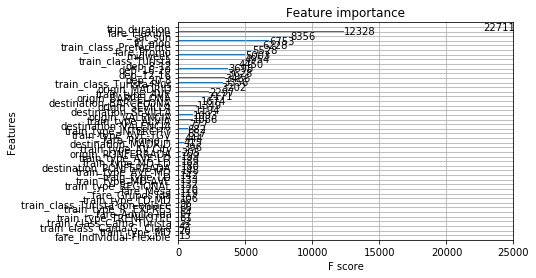

In [30]:
xgb_reg = xgb.XGBRegressor(**best_result['params'], nthreads=-1)
xgb_reg.fit(X_train, Y_train)
xgb.plot_importance(xgb_reg)
y_pred = xgb_reg.predict(X_test)

In [31]:
y_pred = xgb_reg.predict(X_test)

In [32]:
rmsle(Y_test, y_pred)

0.1412829784389778